In [1]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import seaborn as sns
import itertools
import warnings

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, ElasticNet

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb

warnings.filterwarnings("ignore", message=".*force_all_finite.*was renamed to 'ensure_all_finite'.*")

# Import Data

used variables:
Total vehicles sold (Target)
- 'Company car tax rate (%)'
- 'Google  Home charging (G)'
- Consumer confidence
- Avergae gas price





In [2]:
# Load data
df = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\AVG_Gas.csv")
df["Time Period (T)"] = pd.to_datetime(df["Time Period (T)"], format="%Y-%m-%d")
df = df.sort_values("Time Period (T)").reset_index(drop=True)
display(df.head())

,Time Period (T),Home charging (G),Electric car (G),Hybrid electric (G),Company car tax rate (%),Consumer confidence (E),Economic climate perception (E),Willingness to buy (E),Major purchases sentiment (E),Gasoline (Euro95) - Average price (F),Diesel - Average price (F),Total vehicles sold (Target)
0,2007-01-01,0,1,0,22,20.0,37.0,9.0,8.0,1.303032,0.970000,31
1,2007-02-01,0,0,0,22,20.0,37.0,9.0,8.0,1.325357,0.990000,39
2,2007-03-01,0,0,0,22,20.0,37.0,9.0,8.0,1.379032,1.006323,123
3,2007-04-01,0,0,0,22,20.0,37.0,9.0,8.0,1.426500,1.030600,62
4,2007-05-01,0,2,0,22,18.0,32.0,9.0,7.4,1.466516,1.032323,84


# 1. Apply train/val/test split

In [3]:
# Define features and target
features = ['Company car tax rate (%)', 'Home charging (G)', 'Consumer confidence (E)', 'Gasoline (Euro95) - Average price (F)']
target = 'Total vehicles sold (Target)'

# Calculate split indices
n = len(df)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

# Split the target
y = df[target]
y_train = y.iloc[:train_end]
y_val = y.iloc[train_end:val_end]
y_test = y.iloc[val_end:]

# Split each feature separately
companytax_train = df['Company car tax rate (%)'].iloc[:train_end]
companytax_val = df['Company car tax rate (%)'].iloc[train_end:val_end]
companytax_test = df['Company car tax rate (%)'].iloc[val_end:]

homechg_train = df['Home charging (G)'].iloc[:train_end]
homechg_val = df['Home charging (G)'].iloc[train_end:val_end]
homechg_test = df['Home charging (G)'].iloc[val_end:]

conf_train = df['Consumer confidence (E)'].iloc[:train_end]
conf_val = df['Consumer confidence (E)'].iloc[train_end:val_end]
conf_test = df['Consumer confidence (E)'].iloc[val_end:]

# Split gasoline price feature
gas_train = df['Gasoline (Euro95) - Average price (F)'].iloc[:train_end]
gas_val = df['Gasoline (Euro95) - Average price (F)'].iloc[train_end:val_end]
gas_test = df['Gasoline (Euro95) - Average price (F)'].iloc[val_end:]

# Print sizes
print(f"Train size: {len(y_train)}, Val size: {len(y_val)}, Test size: {len(y_test)}")


# Print each dataset
print("y_train:\n", y_train.head(), "\n")
print("y_val:\n", y_val.head(), "\n")
print("y_test:\n", y_test.head(), "\n")

print("companytax_train:\n", companytax_train.head(), "\n")
print("companytax_val:\n", companytax_val.head(), "\n")
print("companytax_test:\n", companytax_test.head(), "\n")

print("homechg_train:\n", homechg_train.head(), "\n")
print("homechg_val:\n", homechg_val.head(), "\n")
print("homechg_test:\n", homechg_test.head(), "\n")

print("conf_train:\n", conf_train.head(), "\n")
print("conf_val:\n", conf_val.head(), "\n")
print("conf_test:\n", conf_test.head(), "\n")

print("gas_train:\n", gas_train.head(), "\n")
print("gas_val:\n", gas_val.head(), "\n")
print("gas_test:\n", gas_test.head(), "\n")

# Show percentage of each split
print(f"Train: {len(y_train)/n:.1%}, Val: {len(y_val)/n:.1%}, Test: {len(y_test)/n:.1%}")



Train size: 173, Val size: 22, Test size: 22
y_train:
 0     31
1     39
2    123
3     62
4     84
Name: Total vehicles sold (Target), dtype: int64 

y_val:
 173    15736
174    14522
175    14615
176    15143
177    14904
Name: Total vehicles sold (Target), dtype: int64 

y_test:
 195    18281
196    22305
197    27262
198    27851
199    22109
Name: Total vehicles sold (Target), dtype: int64 

companytax_train:
 0    22
1    22
2    22
3    22
4    22
Name: Company car tax rate (%), dtype: int64 

companytax_val:
 173    12
174    12
175    12
176    12
177    12
Name: Company car tax rate (%), dtype: int64 

companytax_test:
 195    16
196    16
197    16
198    16
199    16
Name: Company car tax rate (%), dtype: int64 

homechg_train:
 0    0
1    0
2    0
3    0
4    0
Name: Home charging (G), dtype: int64 

homechg_val:
 173    51
174    60
175    70
176    71
177    73
Name: Home charging (G), dtype: int64 

homechg_test:
 195    58
196    61
197    50
198    65
199    73
Name:

# 2. Plot all data and boxcox transform it

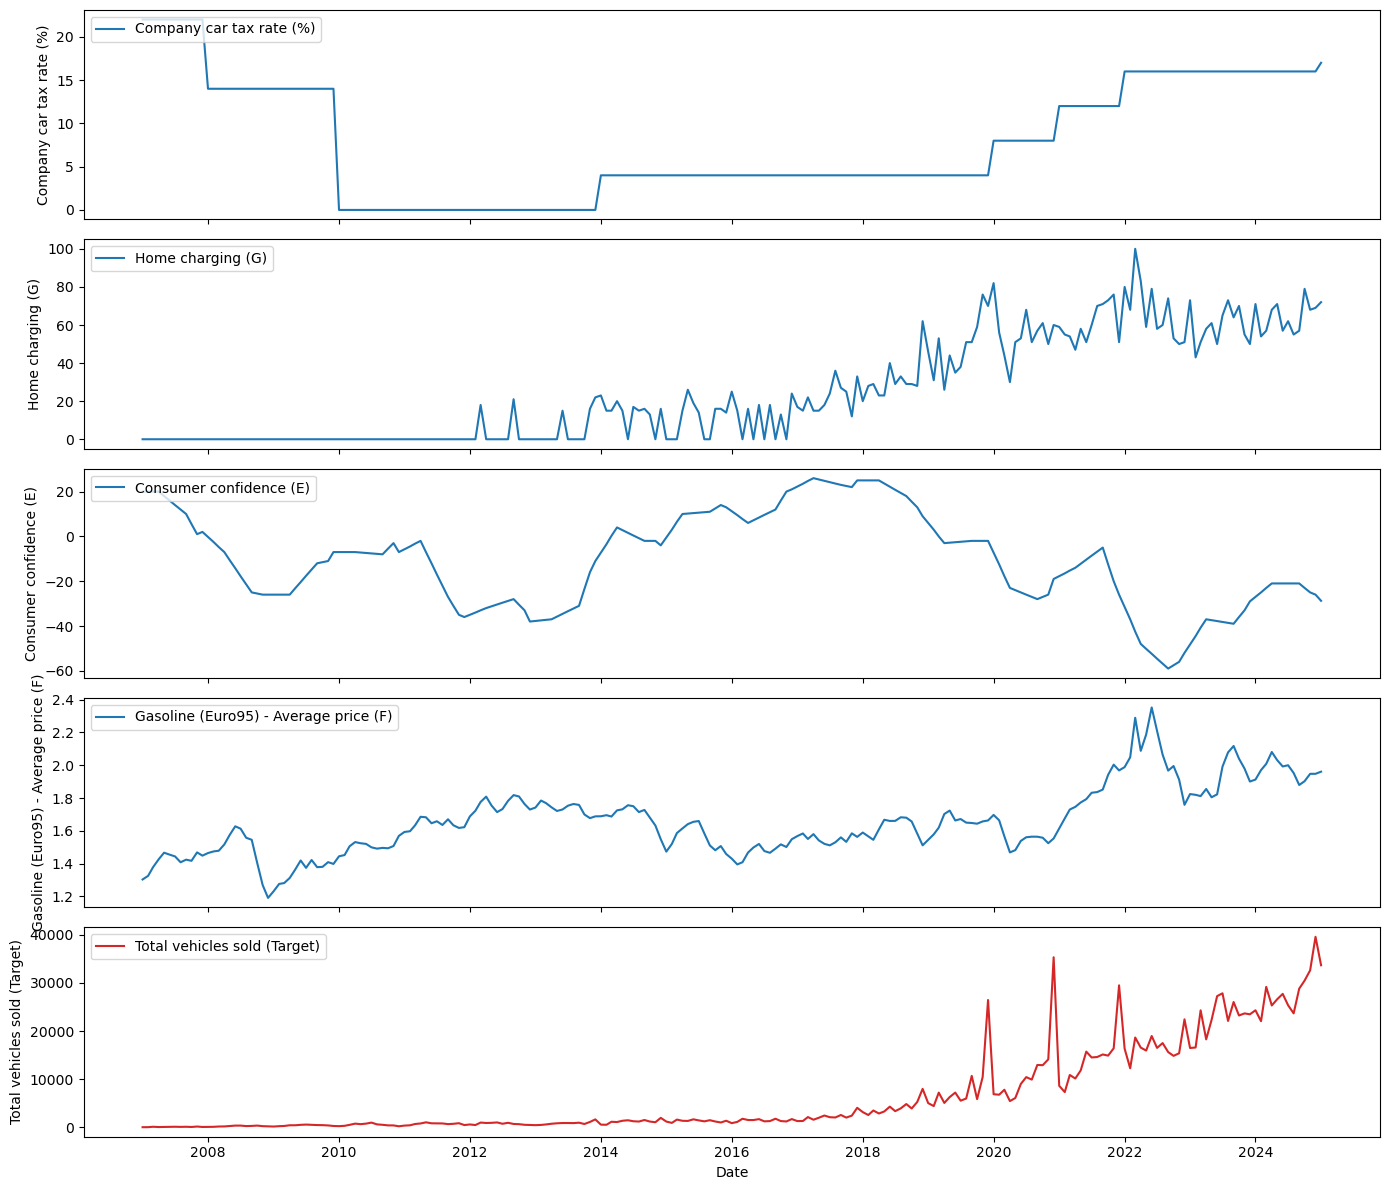

In [4]:
fig, axs = plt.subplots(len(features) + 1, 1, figsize=(14, 12), sharex=True)

for i, col in enumerate(features):
    axs[i].plot(df["Time Period (T)"], df[col], label=col)
    axs[i].set_ylabel(col)
    axs[i].legend(loc="upper left")

axs[-1].plot(df["Time Period (T)"], df[target], label=target, color='tab:red')
axs[-1].set_ylabel(target)
axs[-1].set_xlabel("Date")
axs[-1].legend(loc="upper left")

plt.tight_layout()
plt.show()

Company car tax rate (%): lambda=0.3553071918642989, shift=1
Home charging (G): lambda=0.1026320662583565, shift=1
Consumer confidence (E): lambda=0.9074223886617425, shift=60.0
Gasoline (Euro95) - Average price (F): lambda=-0.8394601069903194, shift=0
Total vehicles sold (Target): lambda=-0.002079636725042893, shift=0


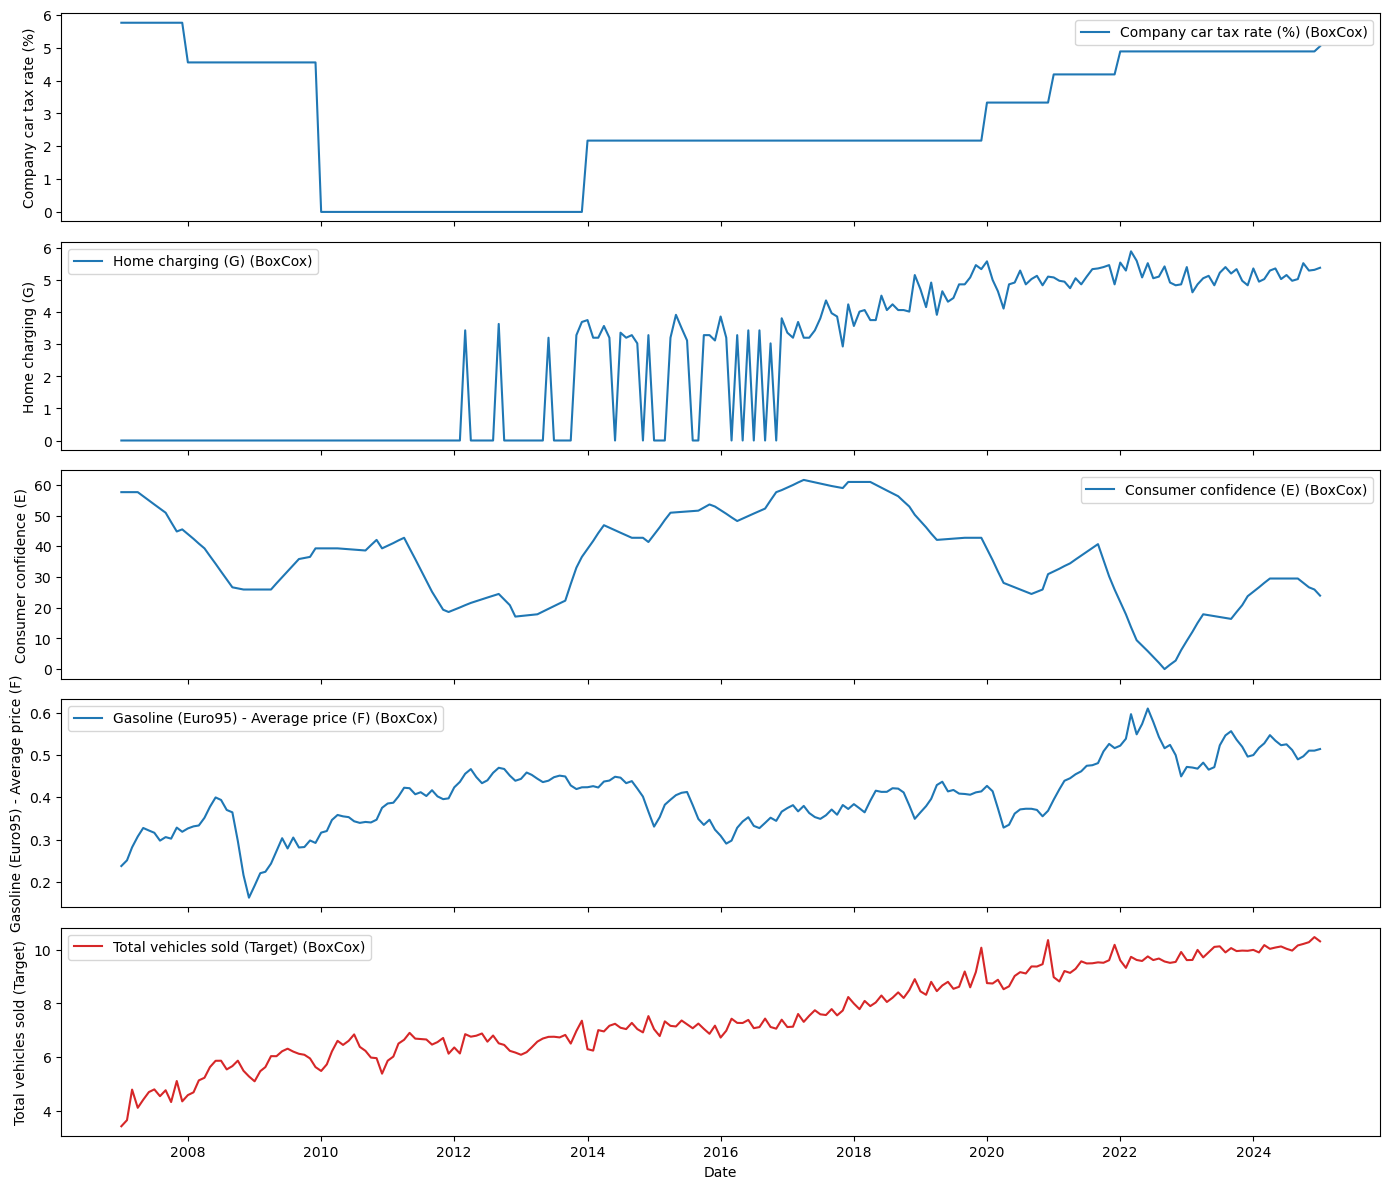

In [5]:
from scipy.stats import boxcox
import numpy as np
import matplotlib.pyplot as plt


features = ['Company car tax rate (%)', 'Home charging (G)', 'Consumer confidence (E)', 'Gasoline (Euro95) - Average price (F)']
target = 'Total vehicles sold (Target)'
# Find optimal lambda and shift for each feature and target on the whole dataset
boxcox_all = {}
boxcox_lambdas_all = {}

for col in features + [target]:
    series = df[col]
    min_val = series.min()
    if min_val <= 0:
        shift = -min_val + 1
        series_shifted = series + shift
    else:
        shift = 0
        series_shifted = series
    transformed, lam = boxcox(series_shifted)
    boxcox_all[col] = transformed
    boxcox_lambdas_all[col] = (lam, shift)
    print(f"{col}: lambda={lam}, shift={shift}")

# Plot BoxCox-transformed data for all features and target

fig, axs = plt.subplots(len(features) + 1, 1, figsize=(14, 12), sharex=True)
for i, col in enumerate(features):
    axs[i].plot(df["Time Period (T)"], boxcox_all[col], label=f"{col} (BoxCox)")
    axs[i].set_ylabel(col)
    axs[i].legend()
axs[-1].plot(df["Time Period (T)"], boxcox_all[target], label=f"{target} (BoxCox)", color='tab:red')
axs[-1].set_ylabel(target)
axs[-1].set_xlabel("Date")
axs[-1].legend()
plt.tight_layout()
plt.show()




#### Train

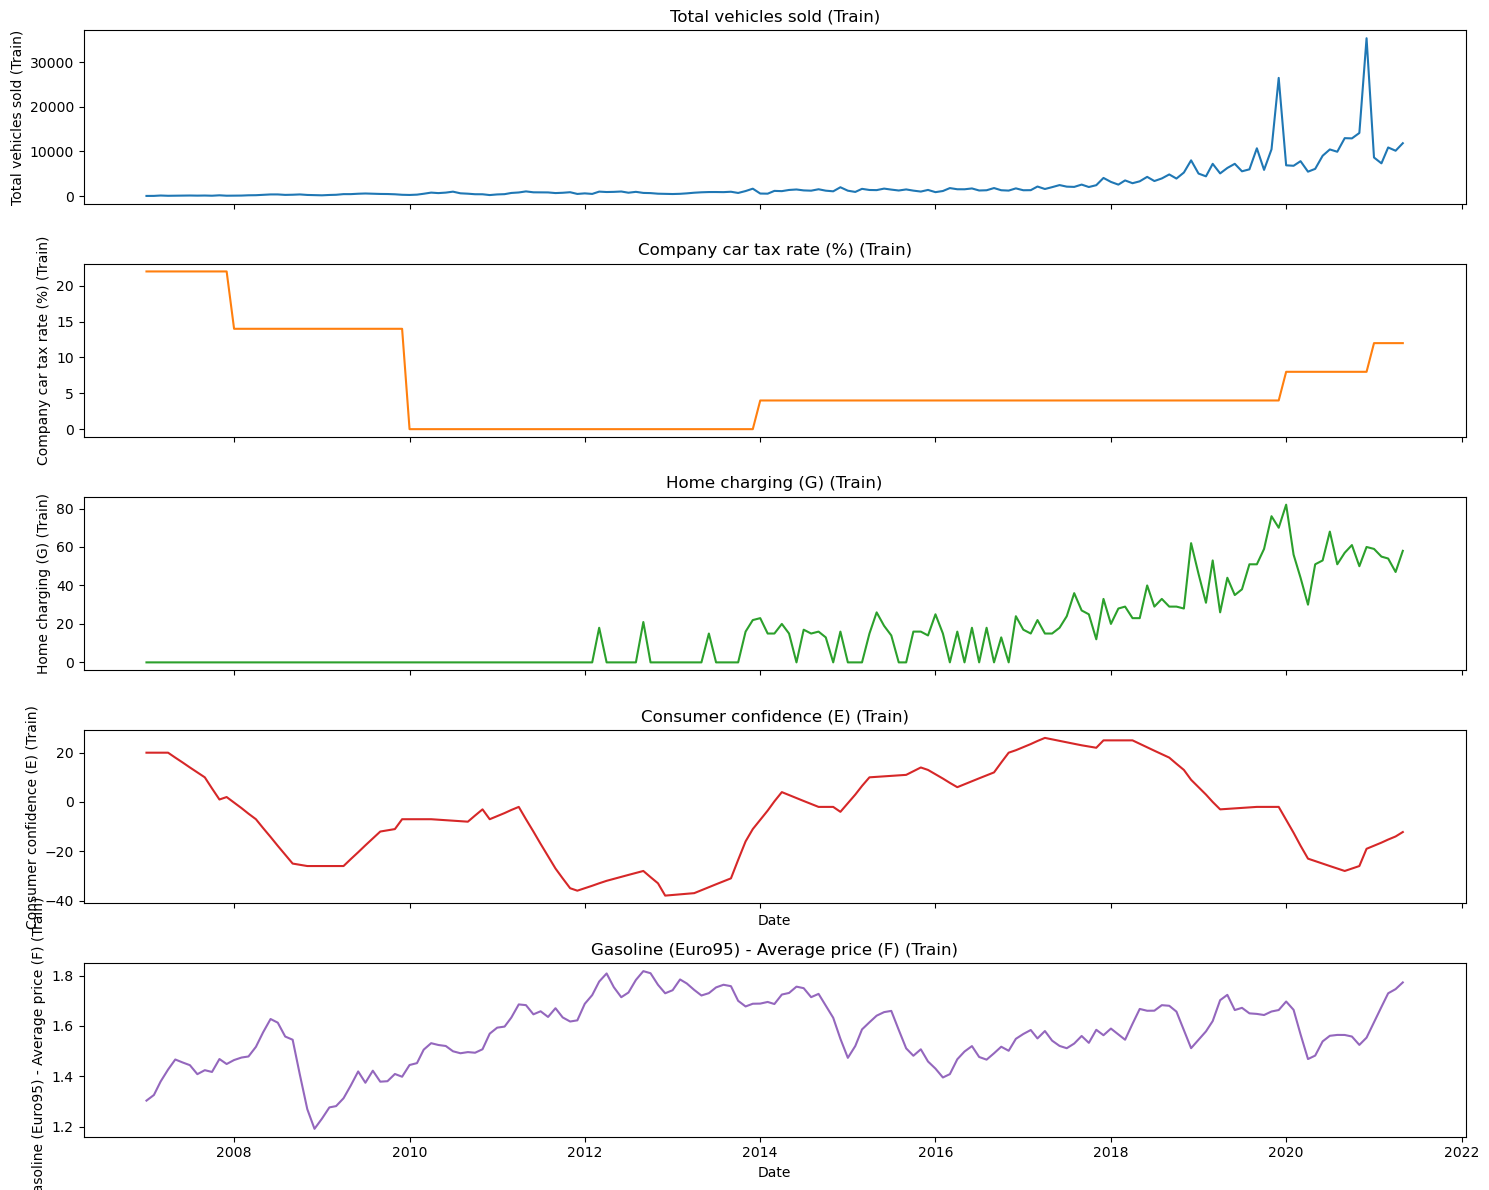

In [6]:
fig, axs = plt.subplots(5, 1, figsize=(15, 12), sharex=True)

date_train = df["Time Period (T)"][:len(y_train)]

axs[0].plot(date_train, y_train, color='tab:blue')
axs[0].set_ylabel('Total vehicles sold (Train)')
axs[0].set_title('Total vehicles sold (Train)')

axs[1].plot(date_train, companytax_train, color='tab:orange')
axs[1].set_ylabel('Company car tax rate (%) (Train)')
axs[1].set_title('Company car tax rate (%) (Train)')

axs[2].plot(date_train, homechg_train, color='tab:green')
axs[2].set_ylabel('Home charging (G) (Train)')
axs[2].set_title('Home charging (G) (Train)')

axs[3].plot(date_train, conf_train, color='tab:red')
axs[3].set_ylabel('Consumer confidence (E) (Train)')
axs[3].set_title('Consumer confidence (E) (Train)')
axs[3].set_xlabel('Date')


axs[4].plot(date_train, gas_train, color='tab:purple')
axs[4].set_ylabel('Gasoline (Euro95) - Average price (F) (Train)')
axs[4].set_title('Gasoline (Euro95) - Average price (F) (Train)')
axs[4].set_xlabel('Date')



plt.tight_layout()
plt.show()

Company car tax rate (%): λ = 0.3553, shift = 1
Home charging (G): λ = 0.1026, shift = 1
Consumer confidence (E): λ = 0.9074, shift = 60.0
Gasoline (Euro95) - Average price (F): λ = -0.8395, shift = 0
Total vehicles sold (Target): λ = -0.0021, shift = 0


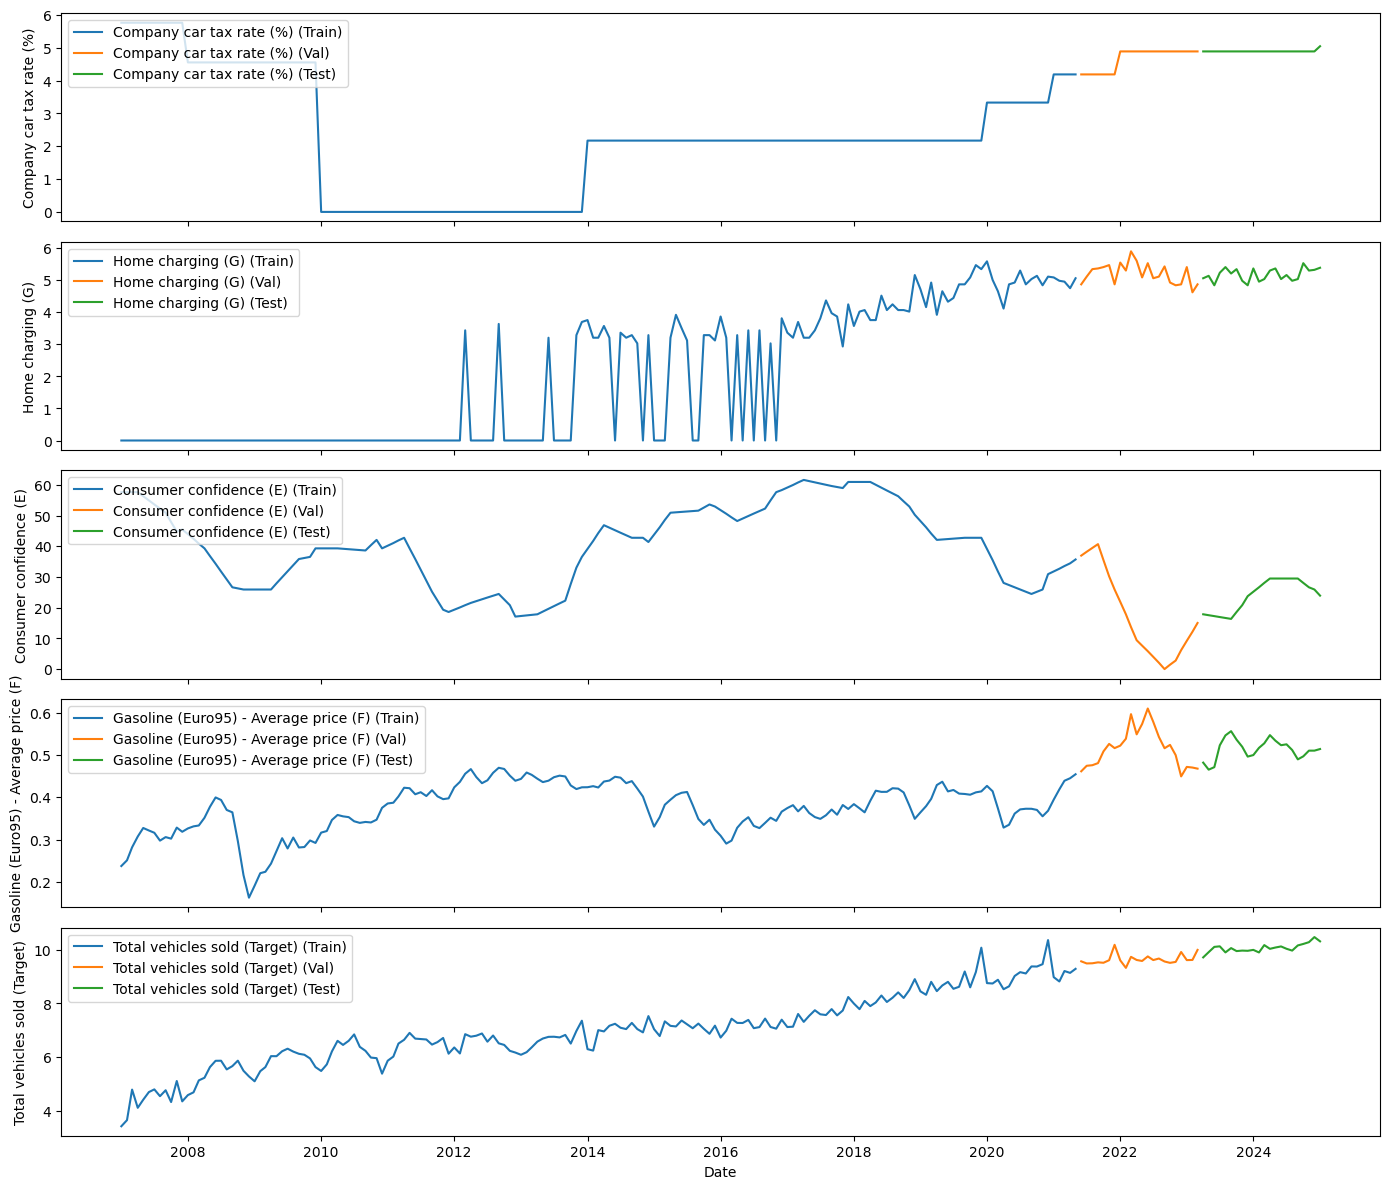

In [7]:
from scipy.stats import boxcox
import numpy as np
import matplotlib.pyplot as plt

# Splits instellen (80/10/10)
n = len(df)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

# Opslag
boxcox_all = {}
boxcox_lambdas_all = {}

# Bereken BoxCox over de hele dataset (met correcte shift)
for col in features + [target]:
    series = df[col]
    min_val = series.min()
    if min_val <= 0:
        shift = -min_val + 1
        series_shifted = series + shift
    else:
        shift = 0
        series_shifted = series
    transformed, lam = boxcox(series_shifted)
    boxcox_all[col] = transformed
    boxcox_lambdas_all[col] = (lam, shift)
    print(f"{col}: λ = {lam:.4f}, shift = {shift}")

# Plot per split with date on x-axis
fig, axs = plt.subplots(len(features) + 1, 1, figsize=(14, 12), sharex=True)
for i, col in enumerate(features):
    axs[i].plot(df["Time Period (T)"][:train_end], boxcox_all[col][:train_end], label=f"{col} (Train)", color='tab:blue')
    axs[i].plot(df["Time Period (T)"][train_end:val_end], boxcox_all[col][train_end:val_end], label=f"{col} (Val)", color='tab:orange')
    axs[i].plot(df["Time Period (T)"][val_end:], boxcox_all[col][val_end:], label=f"{col} (Test)", color='tab:green')
    axs[i].set_ylabel(col)
    axs[i].legend(loc="upper left")

# Target plot
axs[-1].plot(df["Time Period (T)"][:train_end], boxcox_all[target][:train_end], label=f"{target} (Train)", color='tab:blue')
axs[-1].plot(df["Time Period (T)"][train_end:val_end], boxcox_all[target][train_end:val_end], label=f"{target} (Val)", color='tab:orange')
axs[-1].plot(df["Time Period (T)"][val_end:], boxcox_all[target][val_end:], label=f"{target} (Test)", color='tab:green')
axs[-1].set_ylabel(target)
axs[-1].set_xlabel("Date")
axs[-1].legend(loc="upper left")

plt.tight_layout()
plt.show()



# 3. run stationary tests

## Target

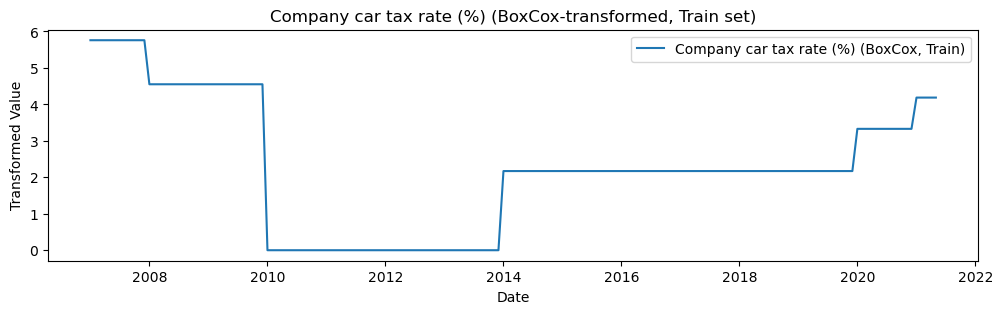

==== Company car tax rate (%) ====
ADF Statistic: -1.9616509753433216
ADF p-value: 0.3036366851664807
ADF Critical Value (1%): -3.4690
ADF Critical Value (5%): -2.8785
ADF Critical Value (10%): -2.5758
ADF: The series is likely non-stationary (fail to reject H0).
KPSS Statistic: 0.3745620074363245
KPSS p-value: 0.0881198243808946
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).



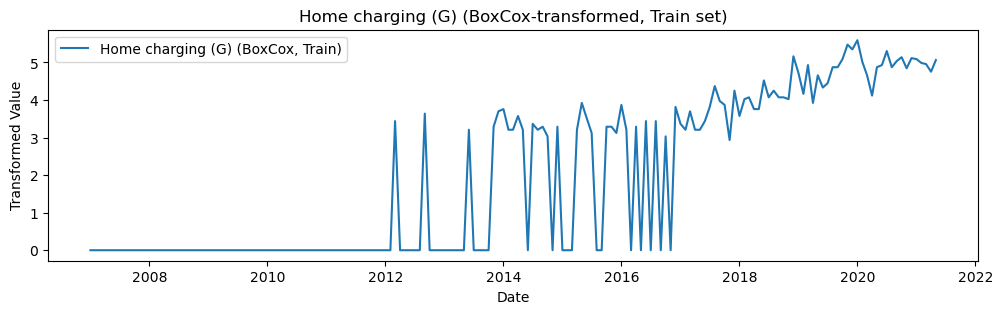

C:\Users\dylan\AppData\Local\Temp\ipykernel_12488\534681784.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(train_bc, regression='c', nlags="auto")


==== Home charging (G) ====
ADF Statistic: -0.20937322979102604
ADF p-value: 0.9373950918228283
ADF Critical Value (1%): -3.4722
ADF Critical Value (5%): -2.8799
ADF Critical Value (10%): -2.5766
ADF: The series is likely non-stationary (fail to reject H0).
KPSS Statistic: 1.8545194253954822
KPSS p-value: 0.01
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely non-stationary (reject H0).



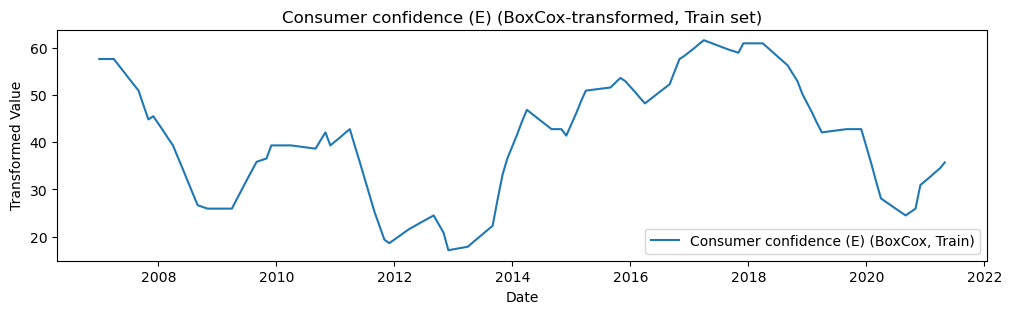

C:\Users\dylan\AppData\Local\Temp\ipykernel_12488\534681784.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(train_bc, regression='c', nlags="auto")


==== Consumer confidence (E) ====
ADF Statistic: -2.3510691792521663
ADF p-value: 0.1560254463294088
ADF Critical Value (1%): -3.4692
ADF Critical Value (5%): -2.8786
ADF Critical Value (10%): -2.5759
ADF: The series is likely non-stationary (fail to reject H0).
KPSS Statistic: 0.3260610689932099
KPSS p-value: 0.1
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).



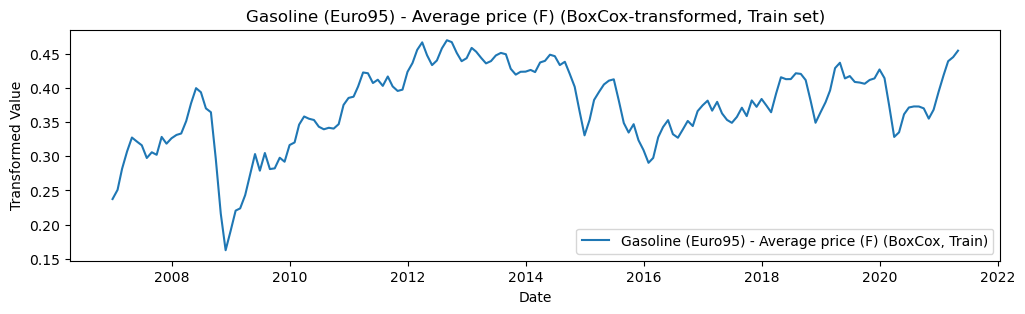

==== Gasoline (Euro95) - Average price (F) ====
ADF Statistic: -3.429561331934728
ADF p-value: 0.009991471463935241
ADF Critical Value (1%): -3.4692
ADF Critical Value (5%): -2.8786
ADF Critical Value (10%): -2.5759
ADF: The series is likely stationary (reject H0).
KPSS Statistic: 0.5550652860343227
KPSS p-value: 0.02926457521749488
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely non-stationary (reject H0).



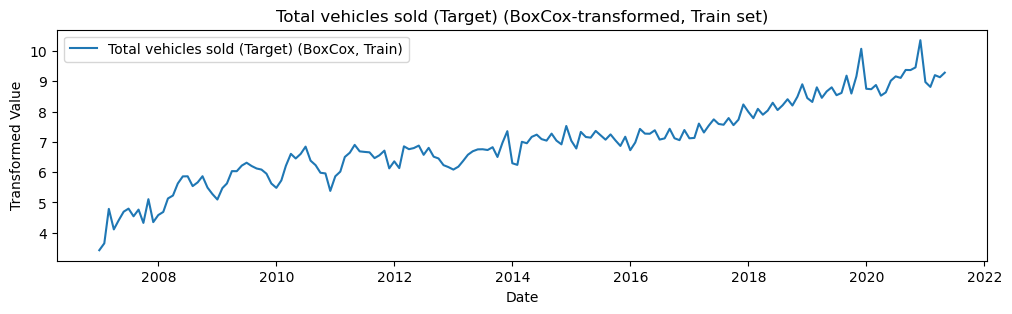

==== Total vehicles sold (Target) ====
ADF Statistic: -0.2734144213478023
ADF p-value: 0.929186159504631
ADF Critical Value (1%): -3.4722
ADF Critical Value (5%): -2.8799
ADF Critical Value (10%): -2.5766
ADF: The series is likely non-stationary (fail to reject H0).
KPSS Statistic: 1.8854846327709538
KPSS p-value: 0.01
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely non-stationary (reject H0).



C:\Users\dylan\AppData\Local\Temp\ipykernel_12488\534681784.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(train_bc, regression='c', nlags="auto")


In [8]:
from statsmodels.tsa.stattools import adfuller, kpss

results = {}

# Loop over features and target
for col in features + [target]:
    # Get BoxCox-transformed train split
    train_bc = boxcox_all[col][:len(y_train)]
    train_dates = df["Time Period (T)"][:len(y_train)]  # Get corresponding dates

    # Plot
    plt.figure(figsize=(12, 3))
    plt.plot(train_dates, train_bc, label=f"{col} (BoxCox, Train)")
    plt.title(f"{col} (BoxCox-transformed, Train set)")
    plt.xlabel("Date")
    plt.ylabel("Transformed Value")
    plt.legend()
    plt.show()
    
    # ADF test
    adf_result = adfuller(train_bc)
    # KPSS test
    kpss_result = kpss(train_bc, regression='c', nlags="auto")
    
    results[col] = {
        "ADF Statistic": adf_result[0],
        "ADF p-value": adf_result[1],
        "ADF Critical Values": adf_result[4],
        "KPSS Statistic": kpss_result[0],
        "KPSS p-value": kpss_result[1],
        "KPSS Critical Values": kpss_result[3]
    }
    
    print(f"\033[1m==== {col} ====\033[0m")
    print("\033[1mADF Statistic:\033[0m", adf_result[0])
    print("\033[1mADF p-value:\033[0m", adf_result[1])
    for key, value in adf_result[4].items():
        print(f"\033[1mADF Critical Value ({key}):\033[0m {value:.4f}")
    if adf_result[1] < 0.05:
        print("\033[1mADF: The series is likely stationary (reject H0).\033[0m")
    else:
        print("\033[1mADF: The series is likely non-stationary (fail to reject H0).\033[0m")
    print("\033[1mKPSS Statistic:\033[0m", kpss_result[0])
    print("\033[1mKPSS p-value:\033[0m", kpss_result[1])
    for key, value in kpss_result[3].items():
        print(f"\033[1mKPSS Critical Value ({key}):\033[0m {value:.4f}")
    if kpss_result[1] < 0.05:
        print("\033[1mKPSS: The series is likely non-stationary (reject H0).\033[0m")
    else:
        print("\033[1mKPSS: The series is likely stationary (fail to reject H0).\033[0m")
    print()

# 4. Apply First/second order differencing

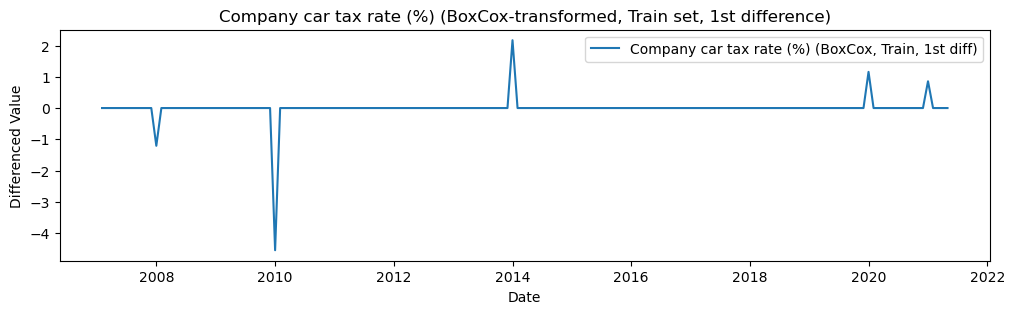

==== Company car tax rate (%) (1st diff) ====
ADF Statistic: -13.006500690837173
ADF p-value: 2.6210848840177814e-24
ADF Critical Value (1%): -3.4692
ADF Critical Value (5%): -2.8786
ADF Critical Value (10%): -2.5759
ADF: The series is likely stationary (reject H0).
KPSS Statistic: 0.3598835944545371
KPSS p-value: 0.09444672652821676
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).



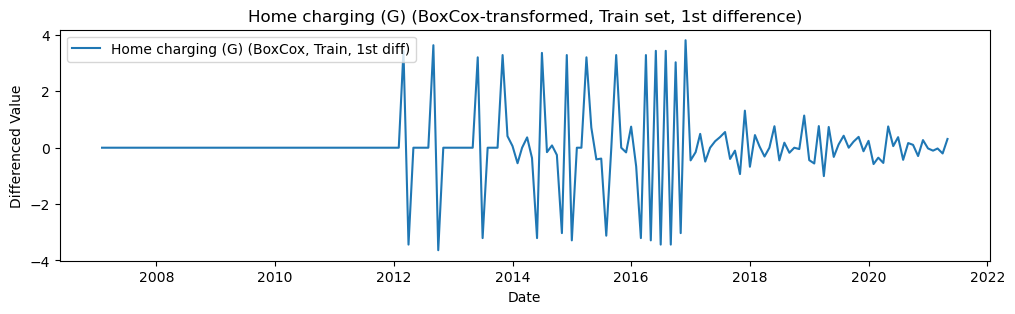

C:\Users\dylan\AppData\Local\Temp\ipykernel_12488\3213974086.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_diff = kpss(train_bc_diff, regression='c', nlags="auto")


==== Home charging (G) (1st diff) ====
ADF Statistic: -5.432745462872665
ADF p-value: 2.8901002355923257e-06
ADF Critical Value (1%): -3.4727
ADF Critical Value (5%): -2.8801
ADF Critical Value (10%): -2.5767
ADF: The series is likely stationary (reject H0).
KPSS Statistic: 0.12832711943021022
KPSS p-value: 0.1
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).



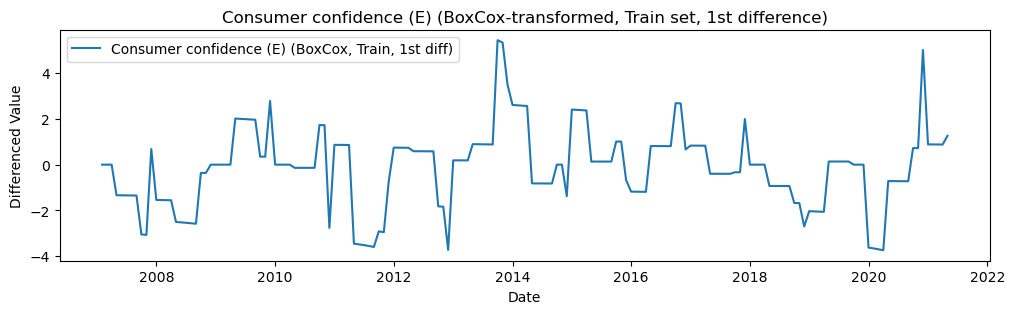

C:\Users\dylan\AppData\Local\Temp\ipykernel_12488\3213974086.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_diff = kpss(train_bc_diff, regression='c', nlags="auto")


==== Consumer confidence (E) (1st diff) ====
ADF Statistic: -5.320846040060335
ADF p-value: 4.9566881976562114e-06
ADF Critical Value (1%): -3.4692
ADF Critical Value (5%): -2.8786
ADF Critical Value (10%): -2.5759
ADF: The series is likely stationary (reject H0).
KPSS Statistic: 0.13959754802959143
KPSS p-value: 0.1
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).



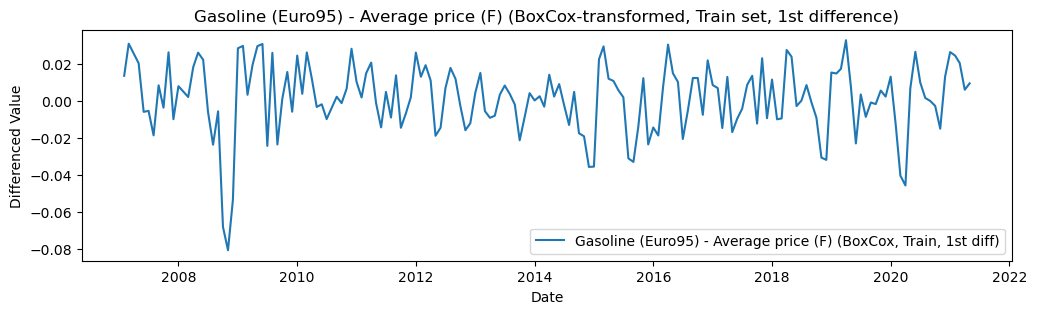

C:\Users\dylan\AppData\Local\Temp\ipykernel_12488\3213974086.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_diff = kpss(train_bc_diff, regression='c', nlags="auto")


==== Gasoline (Euro95) - Average price (F) (1st diff) ====
ADF Statistic: -7.24295525059855
ADF p-value: 1.863648224339432e-10
ADF Critical Value (1%): -3.4704
ADF Critical Value (5%): -2.8791
ADF Critical Value (10%): -2.5761
ADF: The series is likely stationary (reject H0).
KPSS Statistic: 0.08683442785440895
KPSS p-value: 0.1
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).



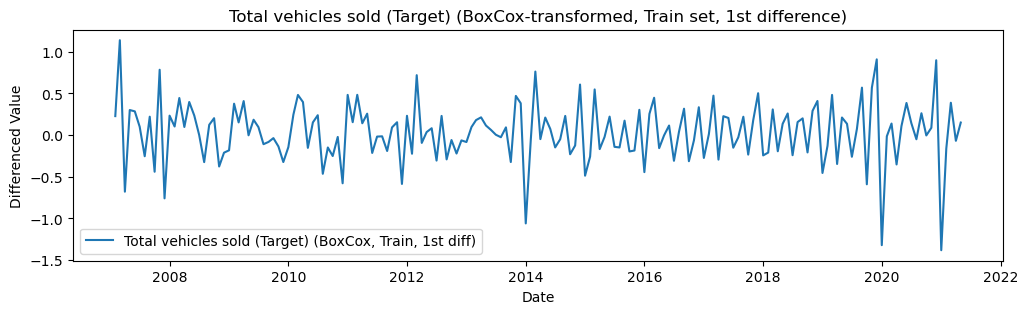

==== Total vehicles sold (Target) (1st diff) ====
ADF Statistic: -3.482309674926358
ADF p-value: 0.008453213503776685
ADF Critical Value (1%): -3.4722
ADF Critical Value (5%): -2.8799
ADF Critical Value (10%): -2.5766
ADF: The series is likely stationary (reject H0).
KPSS Statistic: 0.07044683885481265
KPSS p-value: 0.1
KPSS Critical Value (10%): 0.3470
KPSS Critical Value (5%): 0.4630
KPSS Critical Value (2.5%): 0.5740
KPSS Critical Value (1%): 0.7390
KPSS: The series is likely stationary (fail to reject H0).



C:\Users\dylan\AppData\Local\Temp\ipykernel_12488\3213974086.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_diff = kpss(train_bc_diff, regression='c', nlags="auto")


In [9]:
# Apply first difference to BoxCox-transformed train split for all features and target
diff_results = {}

for col in features + [target]:
    train_bc = boxcox_all[col][:len(y_train)]
    train_bc_diff = np.diff(train_bc, n=1)
    diff_results[col] = train_bc_diff

    # Plot differenced series with date on x-axis
    plt.figure(figsize=(12, 3))
    plt.plot(df["Time Period (T)"][1:len(y_train)], train_bc_diff, label=f"{col} (BoxCox, Train, 1st diff)")
    plt.title(f"{col} (BoxCox-transformed, Train set, 1st difference)")
    plt.xlabel("Date")
    plt.ylabel("Differenced Value")
    plt.legend()
    plt.show()

    # ADF test
    adf_result_diff = adfuller(train_bc_diff)
    # KPSS test
    kpss_result_diff = kpss(train_bc_diff, regression='c', nlags="auto")

    print(f"\033[1m==== {col} (1st diff) ====\033[0m")
    print("\033[1mADF Statistic:\033[0m", adf_result_diff[0])
    print("\033[1mADF p-value:\033[0m", adf_result_diff[1])
    for key, value in adf_result_diff[4].items():
        print(f"\033[1mADF Critical Value ({key}):\033[0m {value:.4f}")
    if adf_result_diff[1] < 0.05:
        print("\033[1mADF: The series is likely stationary (reject H0).\033[0m")
    else:
        print("\033[1mADF: The series is likely non-stationary (fail to reject H0).\033[0m")
    print("\033[1mKPSS Statistic:\033[0m", kpss_result_diff[0])
    print("\033[1mKPSS p-value:\033[0m", kpss_result_diff[1])
    for key, value in kpss_result_diff[3].items():
        print(f"\033[1mKPSS Critical Value ({key}):\033[0m {value:.4f}")
    if kpss_result_diff[1] < 0.05:
        print("\033[1mKPSS: The series is likely non-stationary (reject H0).\033[0m")
    else:
        print("\033[1mKPSS: The series is likely stationary (fail to reject H0).\033[0m")
    print()

#### Plotslater weglaten (dataleakage)

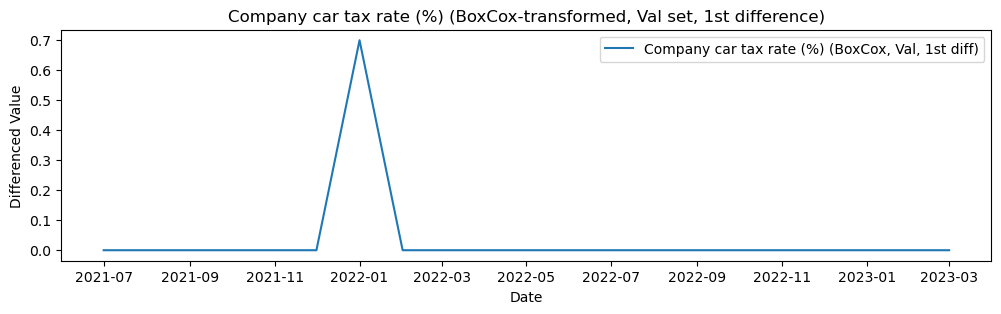

==== Company car tax rate (%) (Val, 1st diff) ====
[0.         0.         0.         0.         0.         0.
 0.70019093 0.         0.         0.        ] ...



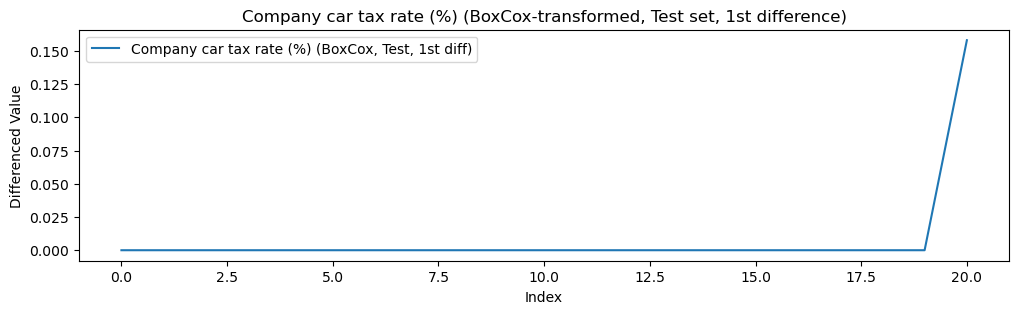

==== Company car tax rate (%) (Test, 1st diff) ====
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...



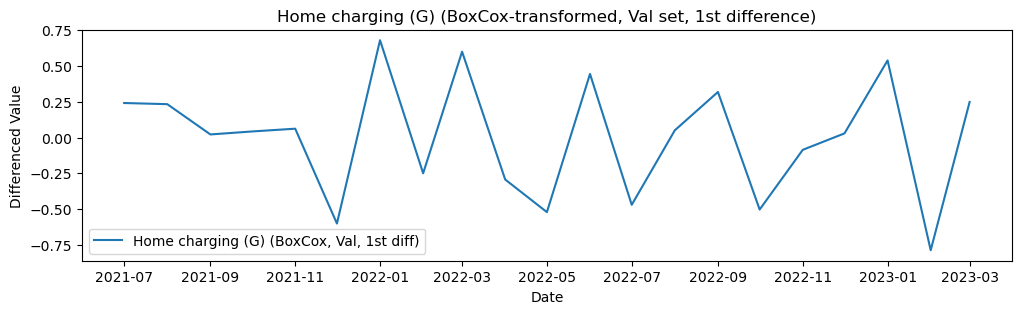

==== Home charging (G) (Val, 1st diff) ====
[ 0.2414317   0.23329673  0.0216776   0.0425566   0.06193848 -0.60090111
  0.6802004  -0.2496619   0.60004646 -0.29318434] ...



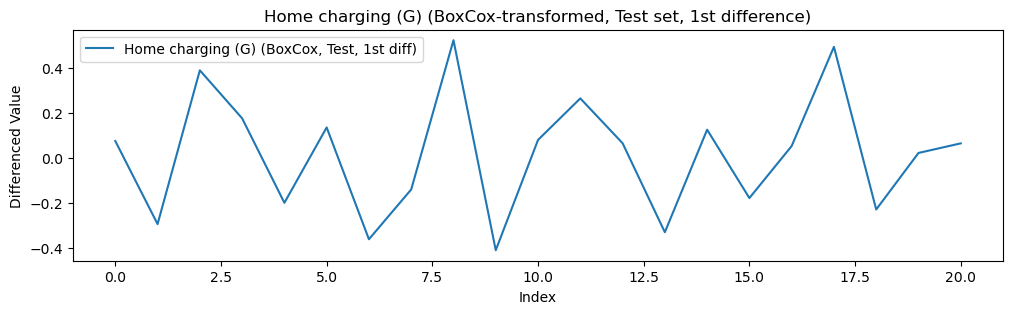

==== Home charging (G) (Test, 1st diff) ====
[ 0.0755626  -0.29534739  0.39114891  0.17691357 -0.20036506  0.13613086
 -0.36313605 -0.14069223  0.52550588 -0.41202421] ...



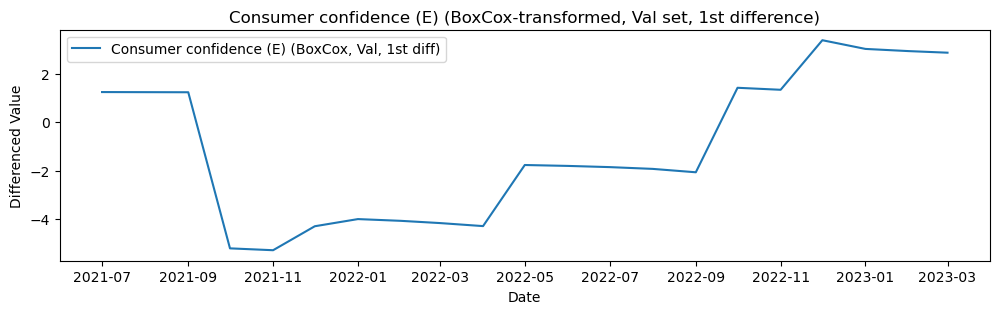

==== Consumer confidence (E) (Val, 1st diff) ====
[ 1.25195346  1.24790031  1.24399682 -5.20980122 -5.28685439 -4.2955533
 -3.99972268 -4.07230322 -4.16440343 -4.28959256] ...



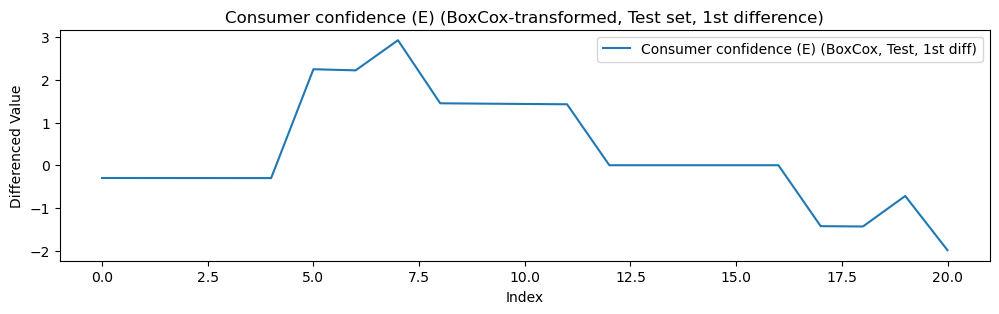

==== Consumer confidence (E) (Test, 1st diff) ====
[-0.29946508 -0.2999562  -0.30045699 -0.30096783 -0.30148912  2.24890967
  2.22296429  2.92893378  1.45108869  1.44296458] ...



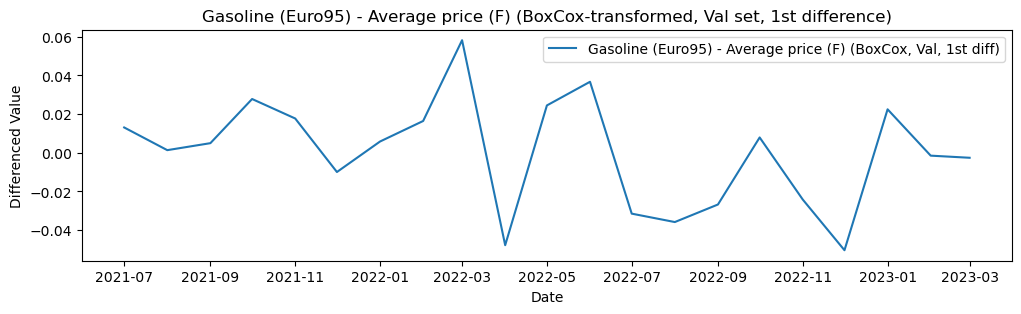

==== Gasoline (Euro95) - Average price (F) (Val, 1st diff) ====
[ 0.01307702  0.00134205  0.00495753  0.02778926  0.0177121  -0.00995884
  0.00581026  0.01642064  0.05818493 -0.04779401] ...



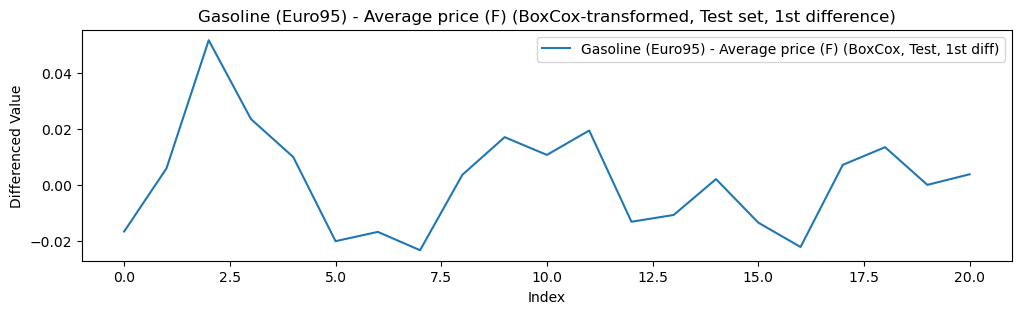

==== Gasoline (Euro95) - Average price (F) (Test, 1st diff) ====
[-0.0166263   0.00589656  0.05170607  0.02353535  0.00995942 -0.02008942
 -0.0167777  -0.02332721  0.00361173  0.01707079] ...



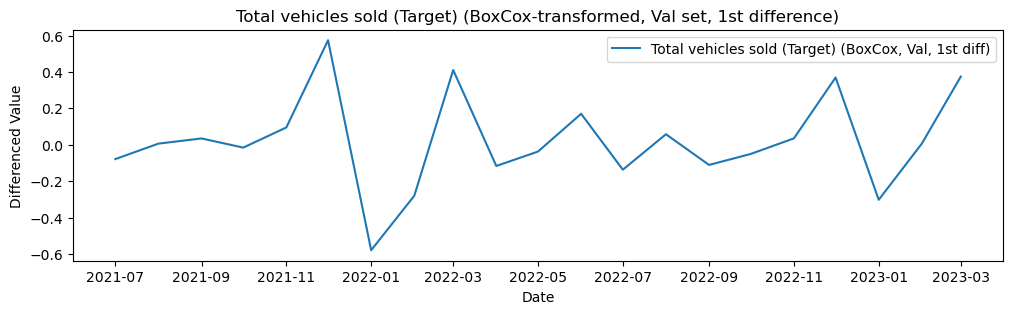

==== Total vehicles sold (Target) (Val, 1st diff) ====
[-0.0786955   0.00625765  0.03478792 -0.01559372  0.09500394  0.57407148
 -0.57903757 -0.28006187  0.41038322 -0.11644389] ...



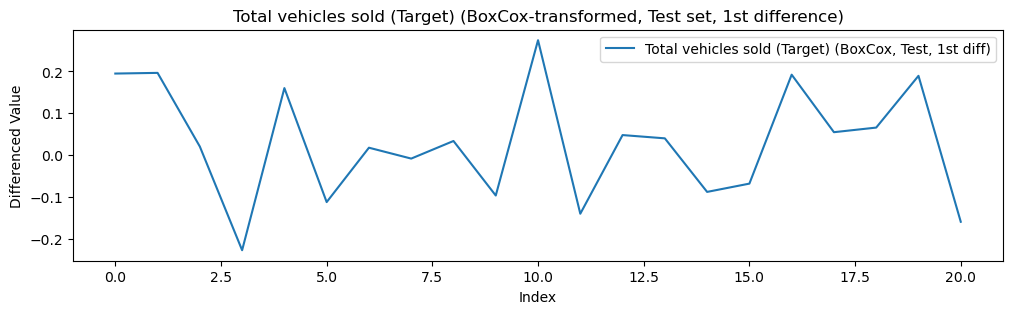

==== Total vehicles sold (Target) (Test, 1st diff) ====
[ 0.19488914  0.1965064   0.0209254  -0.2260761   0.16025237 -0.11139194
  0.01820201 -0.00772365  0.0342051  -0.09571696] ...



In [10]:
# First differencing for BoxCox-transformed val and test splits for all features and target
diff_val_results = {}
diff_test_results = {}

for col in features + [target]:
    # Validation split
    val_bc = boxcox_all[col][train_end:val_end]
    val_bc_diff = np.diff(val_bc, n=1)
    diff_val_results[col] = val_bc_diff

    plt.figure(figsize=(12, 3))
    plt.plot(df["Time Period (T)"][train_end+1:val_end], val_bc_diff, label=f"{col} (BoxCox, Val, 1st diff)")
    plt.title(f"{col} (BoxCox-transformed, Val set, 1st difference)")
    plt.xlabel("Date")
    plt.ylabel("Differenced Value")
    plt.legend()
    plt.show()

    print(f"==== {col} (Val, 1st diff) ====")
    print(val_bc_diff[:10], "...")  # print first 10 values
    print()

    # Test split
    test_bc = boxcox_all[col][val_end:]
    test_bc_diff = np.diff(test_bc, n=1)
    diff_test_results[col] = test_bc_diff

    plt.figure(figsize=(12, 3))
    plt.plot(test_bc_diff, label=f"{col} (BoxCox, Test, 1st diff)")
    plt.title(f"{col} (BoxCox-transformed, Test set, 1st difference)")
    plt.xlabel("Index")
    plt.ylabel("Differenced Value")
    plt.legend()
    plt.show()

    print(f"==== {col} (Test, 1st diff) ====")
    print(test_bc_diff[:10], "...")  # print first 10 values
    print()

## 4a Fit the model for target value

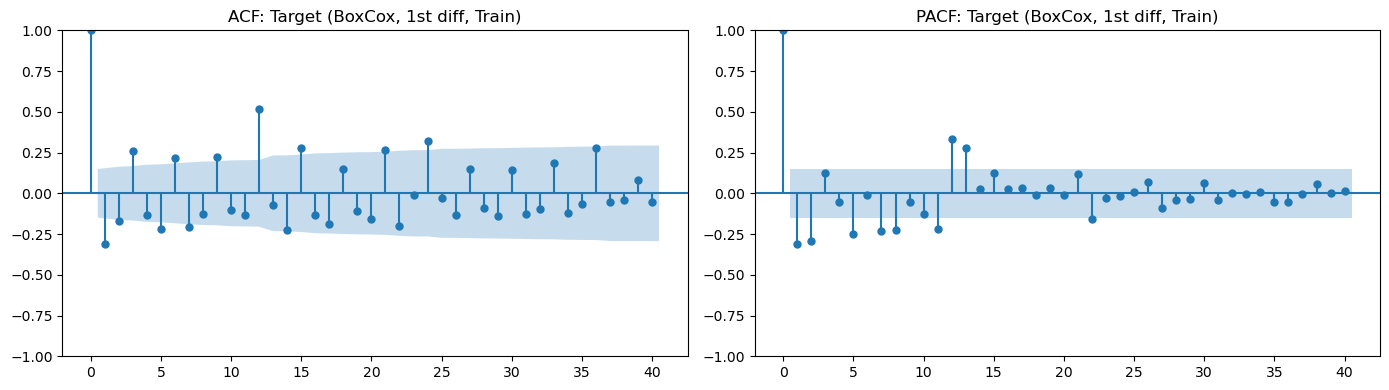

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Use the BoxCox-transformed, first-differenced target from the training set
target_diff = diff_results[target]

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(target_diff, ax=axes[0], lags=40)
axes[0].set_title('ACF: Target (BoxCox, 1st diff, Train)')
plot_pacf(target_diff, ax=axes[1], lags=40, method='ywm')
axes[1].set_title('PACF: Target (BoxCox, 1st diff, Train)')
plt.tight_layout()
plt.show()

In [12]:
import pmdarima as pm

# Gebruik de 1e verschil van je BoxCox-getransformeerde trainingsset
# (bijv. target_diff = np.diff(y_train_boxcox), of y_train_boxcox.diff().dropna())

auto_model = pm.auto_arima(
    y=target_diff,
    d=0,  # ✅ Forceer 1e orde verschil, omdat dat al het beste bleek
    seasonal=False,  # Zet op True als je seizoenspatroon vermoedt
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    max_p=5, max_q=5,
    max_d=0,  # ✅ Laat geen extra differencing meer toe
    information_criterion='aic'
)

print("Best SARIMA order found:", auto_model.order)
print("AIC:", auto_model.aic())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=91.401, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=136.139, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=122.241, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=114.798, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=114.562, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=108.823, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=83.818, Time=0.31 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=109.541, Time=0.10 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=76.253, Time=0.38 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=104.509, Time=0.16 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=108.842, Time=0.45 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=87.818, Time=0.39 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=85.660, Time=0.33 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=100.954, Time=0.17 sec
 ARIMA(5,0,3)(0,0,0)[0]             : AIC=89.016, Ti

In [13]:
import pmdarima as pm

# Mogelijke seizoenslengtes (pas aan indien gewenst)
seasonalities = [3, 6, 12]
best_aic = float('inf')
best_model = None
best_m = None

for m in seasonalities:
    print(f"\n=== Probeer SARIMA met seasonality m={m} ===")
    try:
        model = pm.auto_arima(
            y=target_diff,
            d=0,  # al gedifferentieerd
            seasonal=True,
            m=m,
            stepwise=True,
            trace=True,
            error_action='ignore',
            suppress_warnings=True,
            max_p=5, max_q=5,
            max_d=0,
            max_P=2, max_Q=2,  # seizoenscomponenten
            information_criterion='aic'
        )
        print(f"m={m}: SARIMA order={model.order}, seasonal_order={model.seasonal_order}, AIC={model.aic():.2f}")
        if model.aic() < best_aic:
            best_aic = model.aic()
            best_model = model
            best_m = m
    except Exception as e:
        print(f"m={m}: Error: {e}")

if best_model is not None:
    print(f"\nBeste SARIMA model: m={best_m}, order={best_model.order}, seasonal_order={best_model.seasonal_order}, AIC={best_aic:.2f}")
else:
    print("Geen geschikt SARIMA model gevonden.")


=== Probeer SARIMA met seasonality m=3 ===
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[3] intercept   : AIC=90.108, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[3] intercept   : AIC=136.565, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[3] intercept   : AIC=114.595, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[3] intercept   : AIC=109.219, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[3]             : AIC=136.139, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[3] intercept   : AIC=73.325, Time=0.27 sec
 ARIMA(2,0,2)(0,0,0)[3] intercept   : AIC=90.806, Time=0.23 sec
 ARIMA(2,0,2)(0,0,2)[3] intercept   : AIC=72.507, Time=0.43 sec
 ARIMA(2,0,2)(1,0,2)[3] intercept   : AIC=72.943, Time=0.56 sec
 ARIMA(1,0,2)(0,0,2)[3] intercept   : AIC=99.230, Time=0.35 sec
 ARIMA(2,0,1)(0,0,2)[3] intercept   : AIC=97.416, Time=0.30 sec
 ARIMA(1,0,1)(0,0,2)[3] intercept   : AIC=97.252, Time=0.23 sec
 ARIMA(2,0,2)(0,0,2)[3]             : AIC=84.224, Time=0.29 sec

Best model:  ARIMA(2,0,2)(0,0,2)[3] intercept
Total fit time: 3.590 seconds


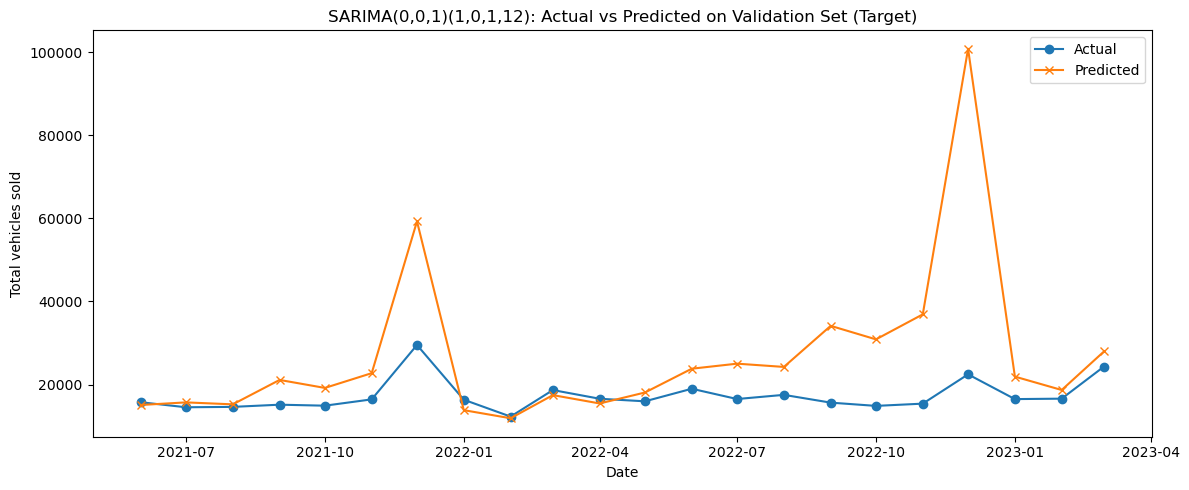

Validation RMSE: 19514.30
Validation MAPE: 52.69%


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA(0,0,1)(1,0,1,12) op BoxCox-getransformeerde trainingset
model = SARIMAX(
    boxcox_all[target][:train_end],
    order=(0, 0, 1),
    seasonal_order=(1, 0, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
fitted_model = model.fit(disp=False)

# Forecast voor validatieset (n_val stappen vooruit)
n_val = len(y_val)
val_forecast_bc = fitted_model.forecast(steps=n_val)

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

val_forecast_orig = inv_boxcox(val_forecast_bc, lam) - shift

# Actuals
actuals = y_val.values

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(df["Time Period (T)"][train_end:val_end], actuals, label='Actual', marker='o')
plt.plot(df["Time Period (T)"][train_end:val_end], val_forecast_orig, label='Predicted', marker='x')
plt.title('SARIMA(0,0,1)(1,0,1,12): Actual vs Predicted on Validation Set (Target)')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(actuals, val_forecast_orig))
mape = mean_absolute_percentage_error(actuals, val_forecast_orig)
print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation MAPE: {mape:.2%}")

### tEST USING ROLING FORCAST. WILL LATER USE ACCUACY VS HORIZON

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


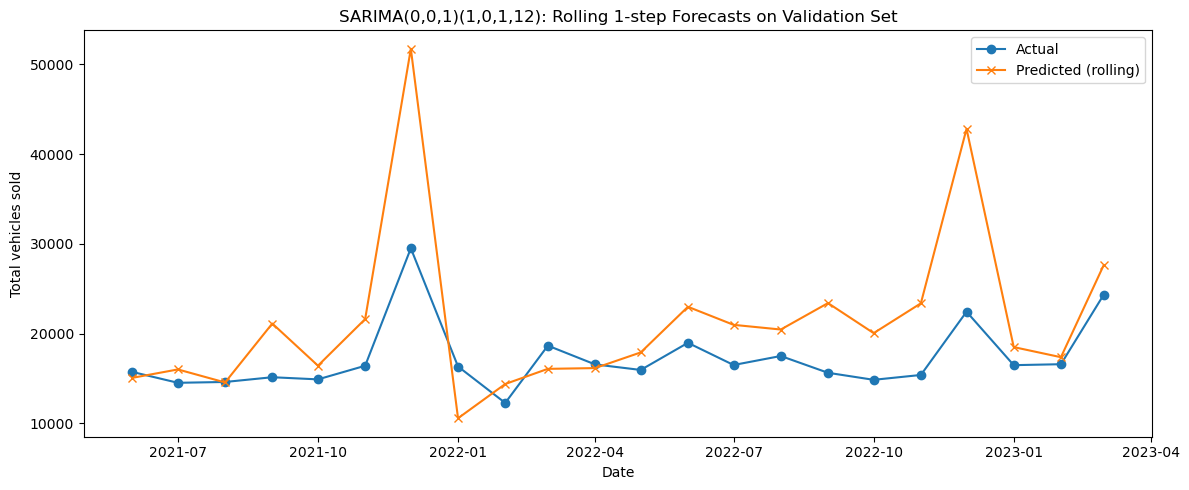

Validation RMSE (rolling): 7497.61
Validation MAPE (rolling): 26.16%


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Walk-forward (rolling) validation for 1-step-ahead forecasts
history = list(boxcox_all[target][:train_end])  # start with train set
val_bc = boxcox_all[target][train_end:val_end]  # validation set (BoxCox-transformed)
predictions_bc = []

for t in range(len(val_bc)):
    model = SARIMAX(
        history,
        order=(0, 0, 1),
        seasonal_order=(1, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)
    yhat = fitted_model.forecast(steps=1)[0]
    predictions_bc.append(yhat)
    # append the true value for next step
    history.append(val_bc[t])

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

val_forecast_orig = inv_boxcox(np.array(predictions_bc), lam) - shift
actuals = y_val.values

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(df["Time Period (T)"][train_end:val_end], actuals, label='Actual', marker='o')
plt.plot(df["Time Period (T)"][train_end:val_end], val_forecast_orig, label='Predicted (rolling)', marker='x')
plt.title('SARIMA(0,0,1)(1,0,1,12): Rolling 1-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(actuals, val_forecast_orig))
mape = mean_absolute_percentage_error(actuals, val_forecast_orig)
print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")

### CAN BE DELETED Adding test to see optimal forcast horizon testing 1,3,6 and 12 months ahead

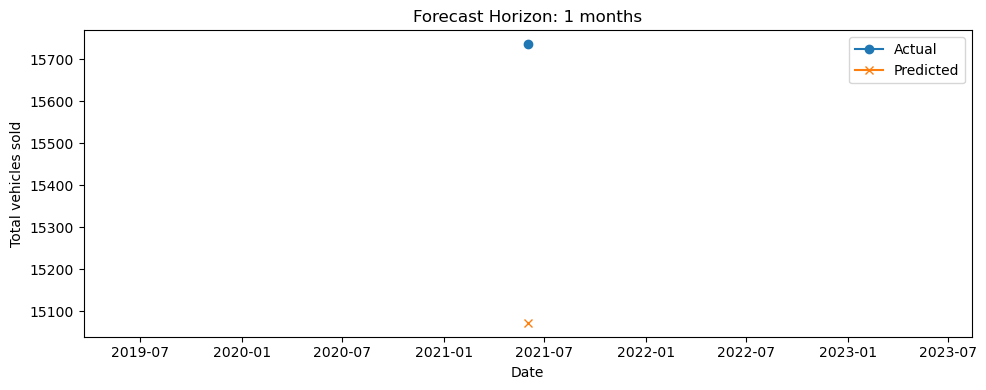

1-Month Forecast --> RMSE: 664.10, MAPE: 4.22%


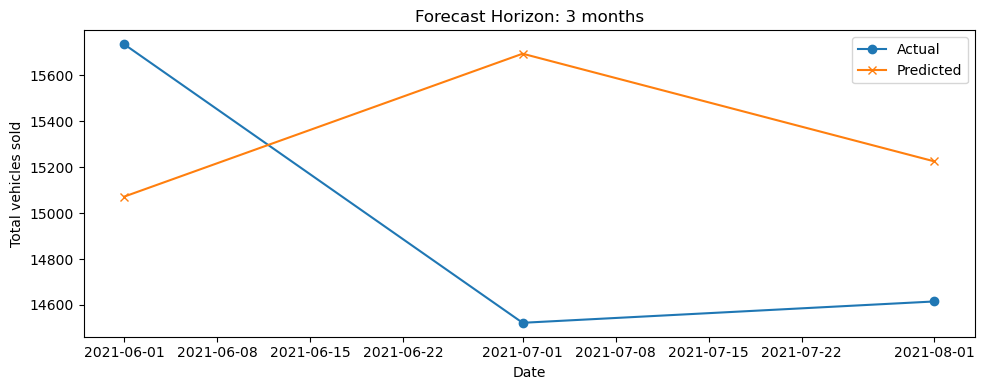

3-Month Forecast --> RMSE: 854.29, MAPE: 5.49%


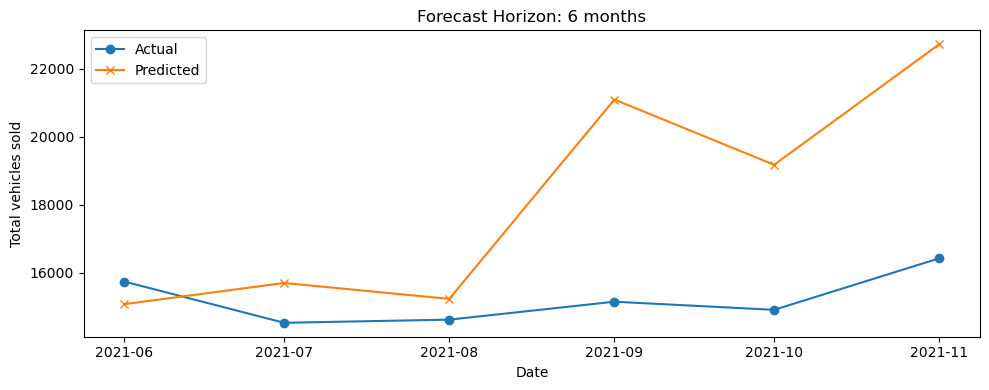

6-Month Forecast --> RMSE: 3992.96, MAPE: 20.48%


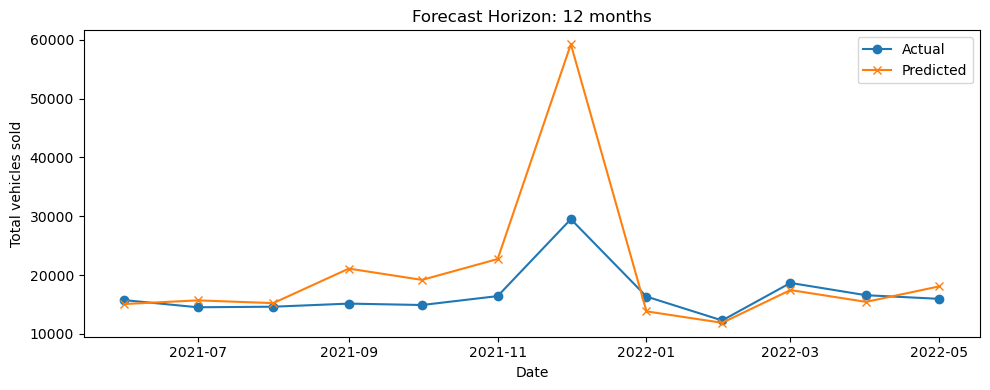

12-Month Forecast --> RMSE: 9104.37, MAPE: 22.41%


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import numpy as np

# Fit SARIMA(0,0,1)(1,0,1,12) model on BoxCox-transformed training set
model = SARIMAX(
    boxcox_all[target][:train_end],
    order=(0, 0, 1),
    seasonal_order=(1, 0, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
fitted_model = model.fit(disp=False)

# Inverse BoxCox transform function
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

# Forecast horizons in months
forecast_horizons = [1, 3, 6, 12]

for horizon in forecast_horizons:
    val_forecast_bc = fitted_model.forecast(steps=horizon)
    val_forecast_orig = inv_boxcox(val_forecast_bc, lam) - shift
    actuals = y_val.values[:horizon]
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 4))
    plt.plot(df["Time Period (T)"][train_end:train_end+horizon], actuals, label='Actual', marker='o')
    plt.plot(df["Time Period (T)"][train_end:train_end+horizon], val_forecast_orig, label='Predicted', marker='x')
    plt.title(f'Forecast Horizon: {horizon} months')
    plt.xlabel('Date')
    plt.ylabel('Total vehicles sold')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Calculate and print RMSE and MAPE
    rmse = np.sqrt(mean_squared_error(actuals, val_forecast_orig))
    mape = mean_absolute_percentage_error(actuals, val_forecast_orig)
    print(f"{horizon}-Month Forecast --> RMSE: {rmse:.2f}, MAPE: {mape:.2%}")


# 5 apply Optimal lag with target model (based on AIC/BIC)

### Gasoline price 

### Company car tax rate (%)

In [15]:
import statsmodels.api as sm

# Prepare exogenous variable: use BoxCox-transformed, 1st-differenced train split for 'Company car tax rate (%)'
exog_feature = diff_results['Company car tax rate (%)']
target_diff = diff_results[target]

# Try lags 1 to 6 for exogenous variable
max_lag = 6
aic_bic_results = []

for lag in range(1, max_lag + 1):
    # Lag exogenous variable (align with target_diff)
    exog_lagged = np.roll(exog_feature, lag)
    exog_lagged[:lag] = np.nan  # first 'lag' values are invalid
    valid_idx = ~np.isnan(exog_lagged)
    y_valid = target_diff[valid_idx]
    exog_valid = exog_lagged[valid_idx].reshape(-1, 1)
    
    # Fit SARIMAX (ARIMA(0,0,0) since already differenced, no AR/MA terms)
    model = sm.tsa.SARIMAX(
        y_valid,
        order=(0, 0, 0),
        exog=exog_valid,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    aic_bic_results.append({
        'lag': lag,
        'AIC': res.aic,
        'BIC': res.bic
    })

# Sort by AIC and BIC
aic_sorted = sorted(aic_bic_results, key=lambda x: x['AIC'])
bic_sorted = sorted(aic_bic_results, key=lambda x: x['BIC'])

print("Optimal lags sorted by AIC:")
for r in aic_sorted:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

print("\nOptimal lags sorted by BIC:")
for r in bic_sorted:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

Optimal lags sorted by AIC:
Lag: 3, AIC: 121.97, BIC: 128.22
Lag: 6, AIC: 122.87, BIC: 129.08
Lag: 4, AIC: 123.14, BIC: 129.37
Lag: 5, AIC: 123.54, BIC: 129.77
Lag: 2, AIC: 124.15, BIC: 130.41
Lag: 1, AIC: 127.14, BIC: 133.42

Optimal lags sorted by BIC:
Lag: 3, AIC: 121.97, BIC: 128.22
Lag: 6, AIC: 122.87, BIC: 129.08
Lag: 4, AIC: 123.14, BIC: 129.37
Lag: 5, AIC: 123.54, BIC: 129.77
Lag: 2, AIC: 124.15, BIC: 130.41
Lag: 1, AIC: 127.14, BIC: 133.42


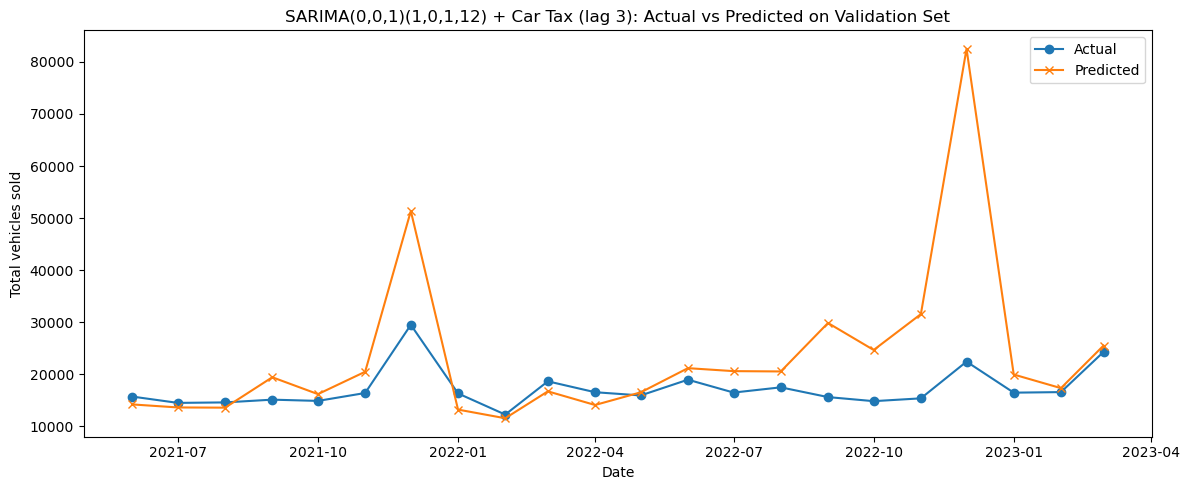

Validation RMSE: 14696.04
Validation MAPE: 37.57%


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prepare exogenous variable: BoxCox-transformed, lagged by 3 (train/val split)
car_tax_bc = boxcox_all['Company car tax rate (%)']
car_tax_train_exog = car_tax_bc[:train_end]
car_tax_val_exog = car_tax_bc[train_end:val_end]

# Lag by 3 (align with SARIMA forecast)
car_tax_train_exog_lag3 = np.roll(car_tax_train_exog, 3)
car_tax_train_exog_lag3[:3] = np.nan  # first 3 values invalid

# Drop first 3 rows from train to align with lagged exog
y_train_bc = boxcox_all[target][:train_end][3:]
car_tax_train_exog_lag3 = car_tax_train_exog_lag3[3:]

# Fit SARIMA with exogenous feature (lag 3)
model = SARIMAX(
    y_train_bc,
    exog=car_tax_train_exog_lag3.reshape(-1, 1),
    order=(0, 0, 1),
    seasonal_order=(1, 0, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
fitted_model = model.fit(disp=False)

# Prepare validation exog (lag 3: use last 3 train values + val)
car_tax_val_exog_full = np.concatenate([car_tax_bc[train_end-3:train_end], car_tax_val_exog])
car_tax_val_exog_lag3 = np.roll(car_tax_val_exog_full, 3)[3:]

# Forecast for validation set
n_val = len(y_val)
val_forecast_bc = fitted_model.forecast(steps=n_val, exog=car_tax_val_exog_lag3.reshape(-1, 1))

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

val_forecast_orig = inv_boxcox(val_forecast_bc, lam) - shift

# Actuals
actuals = y_val.values

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(df["Time Period (T)"][train_end:val_end], actuals, label='Actual', marker='o')
plt.plot(df["Time Period (T)"][train_end:val_end], val_forecast_orig, label='Predicted', marker='x')
plt.title('SARIMA(0,0,1)(1,0,1,12) + Car Tax (lag 3): Actual vs Predicted on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(actuals, val_forecast_orig))
mape = mean_absolute_percentage_error(actuals, val_forecast_orig)
print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation MAPE: {mape:.2%}")

### Google Home Charging

In [17]:
import statsmodels.api as sm

# Use BoxCox-transformed, 1st-differenced train split for 'Home charging (G)'
exog_feature = diff_results['Home charging (G)']
target_diff = diff_results[target]

# Try lags 1 to 6 for exogenous variable
max_lag = 6
aic_bic_results_homechg = []

for lag in range(1, max_lag + 1):
    # Lag exogenous variable (align with target_diff)
    exog_lagged = np.roll(exog_feature, lag)
    exog_lagged[:lag] = np.nan  # first 'lag' values are invalid
    valid_idx = ~np.isnan(exog_lagged)
    y_valid = target_diff[valid_idx]
    exog_valid = exog_lagged[valid_idx].reshape(-1, 1)
    
    # Fit SARIMAX (ARIMA(0,0,0) since already differenced, no AR/MA terms)
    model = sm.tsa.SARIMAX(
        y_valid,
        order=(0, 0, 0),
        exog=exog_valid,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    aic_bic_results_homechg.append({
        'lag': lag,
        'AIC': res.aic,
        'BIC': res.bic
    })

# Sort by AIC and BIC
aic_sorted_homechg = sorted(aic_bic_results_homechg, key=lambda x: x['AIC'])
bic_sorted_homechg = sorted(aic_bic_results_homechg, key=lambda x: x['BIC'])

print("Optimal lags for Home charging (G) sorted by AIC:")
for r in aic_sorted_homechg:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

print("\nOptimal lags for Home charging (G) sorted by BIC:")
for r in bic_sorted_homechg:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

Optimal lags for Home charging (G) sorted by AIC:
Lag: 5, AIC: 120.82, BIC: 127.04
Lag: 4, AIC: 121.93, BIC: 128.17
Lag: 3, AIC: 123.11, BIC: 129.36
Lag: 6, AIC: 123.32, BIC: 129.54
Lag: 2, AIC: 124.16, BIC: 130.42
Lag: 1, AIC: 126.97, BIC: 133.25

Optimal lags for Home charging (G) sorted by BIC:
Lag: 5, AIC: 120.82, BIC: 127.04
Lag: 4, AIC: 121.93, BIC: 128.17
Lag: 3, AIC: 123.11, BIC: 129.36
Lag: 6, AIC: 123.32, BIC: 129.54
Lag: 2, AIC: 124.16, BIC: 130.42
Lag: 1, AIC: 126.97, BIC: 133.25


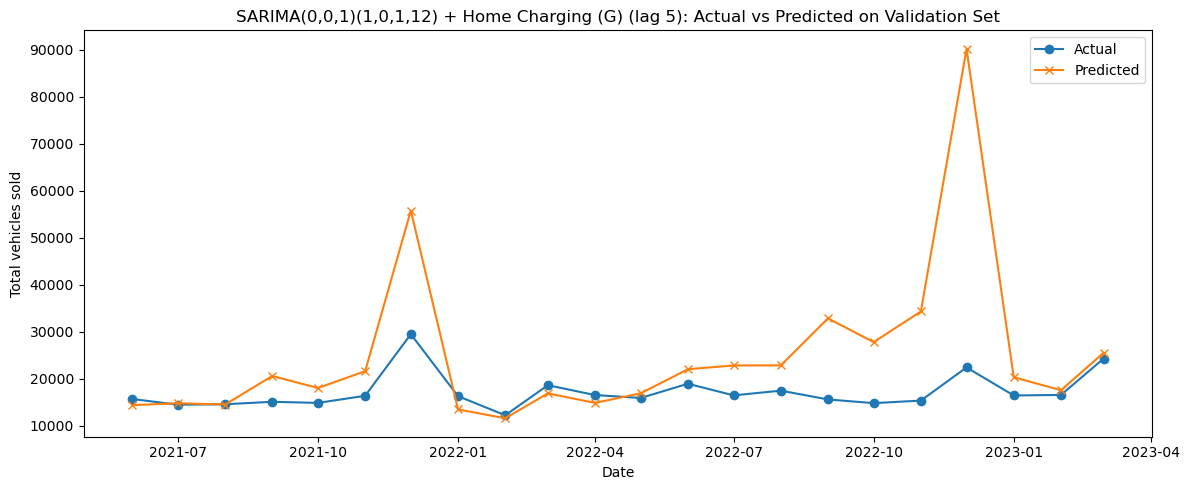

Validation RMSE: 16898.08
Validation MAPE: 44.54%


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prepare exogenous variable: BoxCox-transformed, lagged by 5 (train/val split)
homechg_bc = boxcox_all['Home charging (G)']
homechg_train_exog = homechg_bc[:train_end]
homechg_val_exog = homechg_bc[train_end:val_end]

# Lag by 5 (align with SARIMA forecast)
homechg_train_exog_lag5 = np.roll(homechg_train_exog, 5)
homechg_train_exog_lag5[:5] = np.nan  # first 5 values invalid

# Drop first 5 rows from train to align with lagged exog
y_train_bc = boxcox_all[target][:train_end][5:]
homechg_train_exog_lag5 = homechg_train_exog_lag5[5:]

# Fit SARIMA with exogenous feature (lag 5)
model = SARIMAX(
    y_train_bc,
    exog=homechg_train_exog_lag5.reshape(-1, 1),
    order=(0, 0, 1),
    seasonal_order=(1, 0, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
fitted_model = model.fit(disp=False)

# Prepare validation exog (lag 5: use last 5 train values + val)
homechg_val_exog_full = np.concatenate([homechg_bc[train_end-5:train_end], homechg_val_exog])
homechg_val_exog_lag5 = np.roll(homechg_val_exog_full, 5)[5:]

# Forecast for validation set
n_val = len(y_val)
val_forecast_bc = fitted_model.forecast(steps=n_val, exog=homechg_val_exog_lag5.reshape(-1, 1))

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

val_forecast_orig = inv_boxcox(val_forecast_bc, lam) - shift

# Actuals
actuals = y_val.values

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(df["Time Period (T)"][train_end:val_end], actuals, label='Actual', marker='o')
plt.plot(df["Time Period (T)"][train_end:val_end], val_forecast_orig, label='Predicted', marker='x')
plt.title('SARIMA(0,0,1)(1,0,1,12) + Home Charging (G) (lag 5): Actual vs Predicted on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(actuals, val_forecast_orig))
mape = mean_absolute_percentage_error(actuals, val_forecast_orig)
print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation MAPE: {mape:.2%}")

### Consumer confidence (E)

In [19]:
import statsmodels.api as sm

# Use BoxCox-transformed, 1st-differenced train split for 'Consumer confidence (E)'
exog_feature_conf = np.diff(boxcox_all['Consumer confidence (E)'][:train_end], n=1)
target_diff = train_bc_diff

# Try lags 1 to 6 for exogenous variable
max_lag = 6
aic_bic_results_conf = []

for lag in range(1, max_lag + 1):
    # Lag exogenous variable (align with target_diff)
    exog_lagged = np.roll(exog_feature_conf, lag)
    exog_lagged[:lag] = np.nan  # first 'lag' values are invalid
    valid_idx = ~np.isnan(exog_lagged)
    y_valid = target_diff[valid_idx]
    exog_valid = exog_lagged[valid_idx].reshape(-1, 1)
    
    # Fit SARIMAX (ARIMA(0,0,0) since already differenced, no AR/MA terms)
    model = sm.tsa.SARIMAX(
        y_valid,
        order=(0, 0, 0),
        exog=exog_valid,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    aic_bic_results_conf.append({
        'lag': lag,
        'AIC': res.aic,
        'BIC': res.bic
    })

# Sort by AIC and BIC
aic_sorted_conf = sorted(aic_bic_results_conf, key=lambda x: x['AIC'])
bic_sorted_conf = sorted(aic_bic_results_conf, key=lambda x: x['BIC'])

print("Optimal lags for Consumer confidence (E) sorted by AIC:")
for r in aic_sorted_conf:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

print("\nOptimal lags for Consumer confidence (E) sorted by BIC:")
for r in bic_sorted_conf:
    print(f"Lag: {r['lag']}, AIC: {r['AIC']:.2f}, BIC: {r['BIC']:.2f}")

Optimal lags for Consumer confidence (E) sorted by AIC:
Lag: 6, AIC: 123.13, BIC: 129.34
Lag: 4, AIC: 123.38, BIC: 129.62
Lag: 3, AIC: 123.44, BIC: 129.69
Lag: 5, AIC: 123.55, BIC: 129.78
Lag: 2, AIC: 124.23, BIC: 130.49
Lag: 1, AIC: 127.64, BIC: 133.92

Optimal lags for Consumer confidence (E) sorted by BIC:
Lag: 6, AIC: 123.13, BIC: 129.34
Lag: 4, AIC: 123.38, BIC: 129.62
Lag: 3, AIC: 123.44, BIC: 129.69
Lag: 5, AIC: 123.55, BIC: 129.78
Lag: 2, AIC: 124.23, BIC: 130.49
Lag: 1, AIC: 127.64, BIC: 133.92


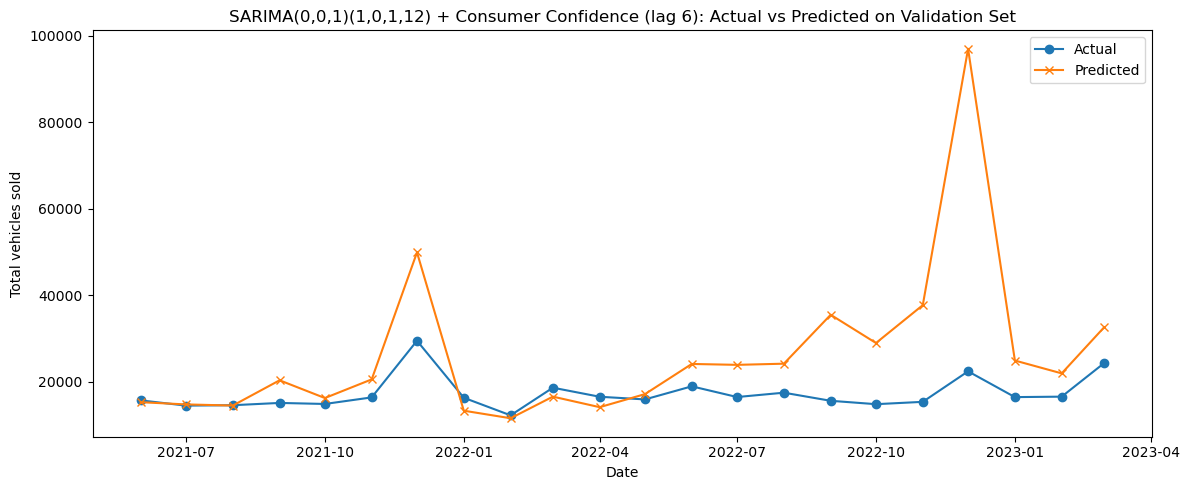

Validation RMSE: 18368.10
Validation MAPE: 51.26%


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prepare exogenous variable: BoxCox-transformed, lagged by 6 (train/val split)
conf_bc = boxcox_all['Consumer confidence (E)']
conf_train_exog = conf_bc[:train_end]
conf_val_exog = conf_bc[train_end:val_end]

# Lag by 6 (align with SARIMA forecast)
conf_train_exog_lag6 = np.roll(conf_train_exog, 6)
conf_train_exog_lag6[:6] = np.nan  # first 6 values invalid

# Drop first 6 rows from train to align with lagged exog
y_train_bc = boxcox_all[target][:train_end][6:]
conf_train_exog_lag6 = conf_train_exog_lag6[6:]

# Fit SARIMA with exogenous feature (lag 6)
model = SARIMAX(
    y_train_bc,
    exog=conf_train_exog_lag6.reshape(-1, 1),
    order=(0, 0, 1),
    seasonal_order=(1, 0, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
fitted_model = model.fit(disp=False)

# Prepare validation exog (lag 6: use last 6 train values + val)
conf_val_exog_full = np.concatenate([conf_bc[train_end-6:train_end], conf_val_exog])
conf_val_exog_lag6 = np.roll(conf_val_exog_full, 6)[6:]

# Forecast for validation set
n_val = len(y_val)
val_forecast_bc = fitted_model.forecast(steps=n_val, exog=conf_val_exog_lag6.reshape(-1, 1))

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

val_forecast_orig = inv_boxcox(val_forecast_bc, lam) - shift

# Actuals
actuals = y_val.values

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(df["Time Period (T)"][train_end:val_end], actuals, label='Actual', marker='o')
plt.plot(df["Time Period (T)"][train_end:val_end], val_forecast_orig, label='Predicted', marker='x')
plt.title('SARIMA(0,0,1)(1,0,1,12) + Consumer Confidence (lag 6): Actual vs Predicted on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(actuals, val_forecast_orig))
mape = mean_absolute_percentage_error(actuals, val_forecast_orig)
print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation MAPE: {mape:.2%}")

### All features together

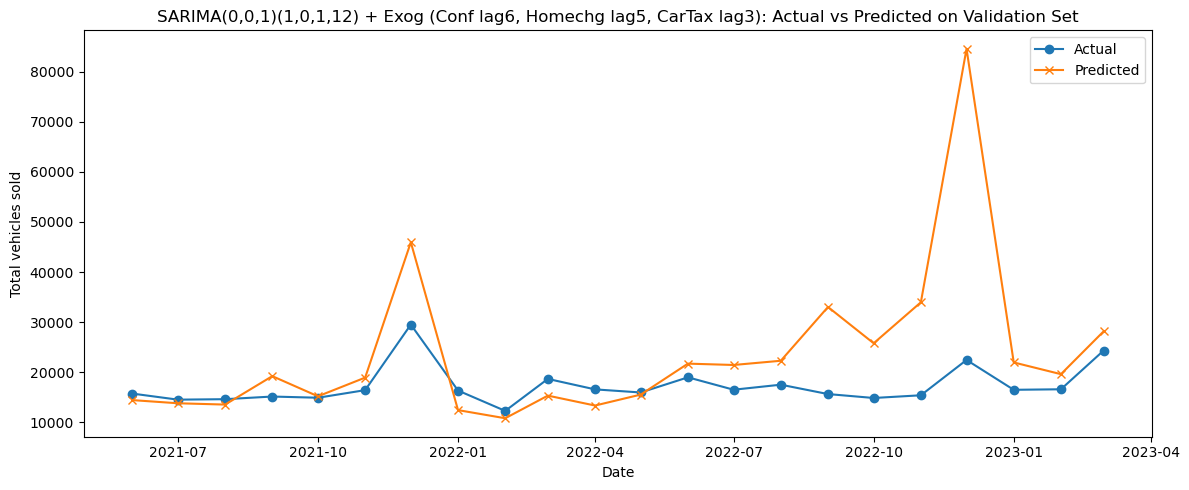

Validation RMSE: 15176.37
Validation MAPE: 41.68%


In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prepare exogenous variables: BoxCox-transformed, lagged by 6/5/3 (train/val split)
conf_bc = boxcox_all['Consumer confidence (E)']
homechg_bc = boxcox_all['Home charging (G)']
car_tax_bc = boxcox_all['Company car tax rate (%)']

# Train splits
conf_train_exog = conf_bc[:train_end]
homechg_train_exog = homechg_bc[:train_end]
car_tax_train_exog = car_tax_bc[:train_end]

# Apply lags
conf_train_exog_lag6 = np.roll(conf_train_exog, 6)
conf_train_exog_lag6[:6] = np.nan

homechg_train_exog_lag5 = np.roll(homechg_train_exog, 5)
homechg_train_exog_lag5[:5] = np.nan

car_tax_train_exog_lag3 = np.roll(car_tax_train_exog, 3)
car_tax_train_exog_lag3[:3] = np.nan

# Align all exogenous variables and target (drop first 6 rows)
y_train_bc = boxcox_all[target][:train_end][6:]
conf_train_exog_lag6 = conf_train_exog_lag6[6:]
homechg_train_exog_lag5 = homechg_train_exog_lag5[6:]
car_tax_train_exog_lag3 = car_tax_train_exog_lag3[6:]

exog_train = np.column_stack([conf_train_exog_lag6, homechg_train_exog_lag5, car_tax_train_exog_lag3])

# Fit SARIMA with all exogenous features
model = SARIMAX(
    y_train_bc,
    exog=exog_train,
    order=(0, 0, 1),
    seasonal_order=(1, 0, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
fitted_model = model.fit(disp=False)

# Prepare validation exog (use last lags from train + val)
conf_val_exog_full = np.concatenate([conf_bc[train_end-6:train_end], conf_bc[train_end:val_end]])
homechg_val_exog_full = np.concatenate([homechg_bc[train_end-5:train_end], homechg_bc[train_end:val_end]])
car_tax_val_exog_full = np.concatenate([car_tax_bc[train_end-3:train_end], car_tax_bc[train_end:val_end]])

conf_val_exog_lag6 = np.roll(conf_val_exog_full, 6)[6:]
homechg_val_exog_lag5 = np.roll(homechg_val_exog_full, 5)[5:]
car_tax_val_exog_lag3 = np.roll(car_tax_val_exog_full, 3)[3:]

exog_val = np.column_stack([conf_val_exog_lag6, homechg_val_exog_lag5, car_tax_val_exog_lag3])

# Forecast for validation set
n_val = len(y_val)
val_forecast_bc = fitted_model.forecast(steps=n_val, exog=exog_val)

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

val_forecast_orig = inv_boxcox(val_forecast_bc, lam) - shift

# Actuals
actuals = y_val.values




# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(df["Time Period (T)"][train_end:val_end], actuals, label='Actual', marker='o')
plt.plot(df["Time Period (T)"][train_end:val_end], val_forecast_orig, label='Predicted', marker='x')
plt.title('SARIMA(0,0,1)(1,0,1,12) + Exog (Conf lag6, Homechg lag5, CarTax lag3): Actual vs Predicted on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(actuals, val_forecast_orig))
mape = mean_absolute_percentage_error(actuals, val_forecast_orig)
print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation MAPE: {mape:.2%}")


# 6 Plot/evaluate with target value

### All features on test 


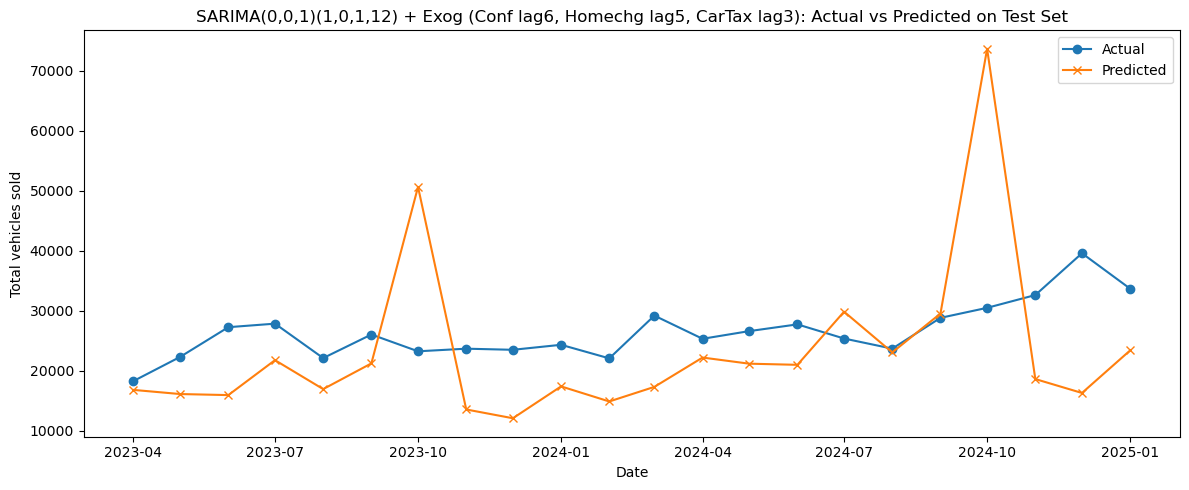

Test RMSE: 13980.82
Test MAPE: 36.65%


In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prepare exogenous variables: BoxCox-transformed, lagged by 6/5/3 (train/test split)
conf_bc = boxcox_all['Consumer confidence (E)']
homechg_bc = boxcox_all['Home charging (G)']
car_tax_bc = boxcox_all['Company car tax rate (%)']

# Train splits
conf_train_exog = conf_bc[:train_end]
homechg_train_exog = homechg_bc[:train_end]
car_tax_train_exog = car_tax_bc[:train_end]

# Apply lags
conf_train_exog_lag6 = np.roll(conf_train_exog, 6)
conf_train_exog_lag6[:6] = np.nan

homechg_train_exog_lag5 = np.roll(homechg_train_exog, 5)
homechg_train_exog_lag5[:5] = np.nan

car_tax_train_exog_lag3 = np.roll(car_tax_train_exog, 3)
car_tax_train_exog_lag3[:3] = np.nan

# Align all exogenous variables and target (drop first 6 rows)
y_train_bc = boxcox_all[target][:train_end][6:]
conf_train_exog_lag6 = conf_train_exog_lag6[6:]
homechg_train_exog_lag5 = homechg_train_exog_lag5[6:]
car_tax_train_exog_lag3 = car_tax_train_exog_lag3[6:]

exog_train = np.column_stack([conf_train_exog_lag6, homechg_train_exog_lag5, car_tax_train_exog_lag3])

# Fit SARIMA with all exogenous features
model = SARIMAX(
    y_train_bc,
    exog=exog_train,
    order=(0, 0, 1),
    seasonal_order=(1, 0, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
fitted_model = model.fit(disp=False)

# Prepare test exog (use last lags from train + test)
conf_test_exog_full = np.concatenate([conf_bc[train_end-6:train_end], conf_bc[train_end:]])
homechg_test_exog_full = np.concatenate([homechg_bc[train_end-5:train_end], homechg_bc[train_end:]])
car_tax_test_exog_full = np.concatenate([car_tax_bc[train_end-3:train_end], car_tax_bc[train_end:]])

conf_test_exog_lag6 = np.roll(conf_test_exog_full, 6)[6:]
homechg_test_exog_lag5 = np.roll(homechg_test_exog_full, 5)[5:]
car_tax_test_exog_lag3 = np.roll(car_tax_test_exog_full, 3)[3:]

# Only select test set indices
n_test = len(y_test)
exog_test = np.column_stack([
    conf_test_exog_lag6[-n_test:],
    homechg_test_exog_lag5[-n_test:],
    car_tax_test_exog_lag3[-n_test:]
])

# Forecast for test set
test_forecast_bc = fitted_model.forecast(steps=n_test, exog=exog_test)

# Inverse BoxCox transform
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1/lam)

test_forecast_orig = inv_boxcox(test_forecast_bc, lam) - shift

# Actuals
actuals = y_test.values

# Plot actual vs predicted
# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(df["Time Period (T)"][val_end:], actuals, label='Actual', marker='o')
plt.plot(df["Time Period (T)"][val_end:], test_forecast_orig, label='Predicted', marker='x')
plt.title('SARIMA(0,0,1)(1,0,1,12) + Exog (Conf lag6, Homechg lag5, CarTax lag3): Actual vs Predicted on Test Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(actuals, test_forecast_orig))
mape = mean_absolute_percentage_error(actuals, test_forecast_orig)
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAPE: {mape:.2%}")
